### Author: Adriano M. Yoshino - amy324@nyu.edu

## PUI Final Exam - Fall 2016

In [199]:
from __future__ import print_function
from matplotlib.colors import ListedColormap 

import geopandas as gpd
import matplotlib as plt
import numpy as np
import os
import pandas as pd
import pylab as pl
import scipy.stats
import shapely
from sklearn.cluster import KMeans
import wget
import zipfile


%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/adrianoyoshino/anaconda/envs/snakes/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['norm', 'f', 'plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### 1. Find the number of businesses in 2010 and 2000. This information is available at the zipcode level (HW11).

### 2. Gather a zipcode shapefile and merge the number of businesses with the zipcode shapfile


In [18]:
# These commands are used to download 2000 and 2010 number of businesses 
# I ran it locally on a MacBook, to run this code on compute, use the commented code below

!curl -O ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp00totals.zip
!curl -O ftp://ftp.census.gov/econ2010/CBP_CSV/zbp10totals.zip
    
# for use on compute
''' 
!wget ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp00totals.zip
!wget ftp://ftp.census.gov/econ2010/CBP_CSV/zbp10totals.zip
'''

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  613k  100  613k    0     0   304k      0  0:00:02  0:00:02 --:--:--  304k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  778k  100  778k    0     0   243k      0  0:00:03  0:00:03 --:--:--  243k


### Downloading and opening zipcodes shapefile

In [7]:
# Downloading zipcode files and moving to PUIDATA folder
wget.download('https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip')
!unzip 'ZIP_CODE_040114.zip'
!mv ZIP* os.getenv('PUIDATA')

Archive:  ZIP_CODE_040114.zip
replace ZIP_CODE_040114.shx? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C
/bin/sh: -c: line 0: syntax error near unexpected token `('
/bin/sh: -c: line 0: `mv ZIP* os.getenv(PUIDATA)'


In [2]:
zipcodes = gpd.GeoDataFrame.from_file('ZIP_CODE_040114.shp')

In [3]:
zipcodes = zipcodes[['ZIPCODE', 'geometry', 'AREA']]
zipcodes.columns = [['zip', 'geometry', 'area']]
zipcodes.head(3)

zip                                           geometry          area
0  11436  POLYGON ((1038098.251871482 188138.3800067157,...  2.269930e+07
1  11213  POLYGON ((1001613.712964058 186926.4395172149,...  2.963100e+07
2  11212  POLYGON ((1011174.275535807 183696.33770971, 1...  4.197210e+07

In [4]:
zipcodes.shape

(263, 3)

### Merging Census Business and Zipcodes information

In [5]:
# Our objective here is to merge all datasets in an unique one, indexed by zipcodes only from NY. The merge function
# can make it happen, using the inner method.
# We saw before that some files has a column called est or EST. Let's make some statements to 
# handle those incompatibilities

files = ['zbp00totals.zip', 'zbp10totals.zip']
name = ['2000', '2010']
i = 0

for fname in files:
    zf = zipfile.ZipFile(fname)
    df = pd.read_csv(zf.open(fname.replace('.zip','.txt')))
    
    # Read file and create a dataframe wit zipcode and establishment columns
    try:
        df = df[['ZIP', 'EST']]
        df = df.rename(columns={'ZIP': 'zip', 'EST': name[i]})
    except:
        df = df[['zip', 'est']]
        df = df.rename(columns={'zip': 'zip', 'est': name[i]})
        
    # Transforming in int for merging compatibility purpose
    zipcodes['zip'] = zipcodes['zip'].astype(int)
        
    zipcodes = pd.merge(zipcodes, df, how='inner', on='zip')

    i = i+1

In [6]:
zipcodes.head()

zip                                           geometry          area  \
0  11436  POLYGON ((1038098.251871482 188138.3800067157,...  2.269930e+07   
1  11213  POLYGON ((1001613.712964058 186926.4395172149,...  2.963100e+07   
2  11212  POLYGON ((1011174.275535807 183696.33770971, 1...  4.197210e+07   
3  11225  POLYGON ((995908.3654508889 183617.6128015518,...  2.369863e+07   
4  11218  POLYGON ((991997.1134308875 176307.4958601296,...  3.686880e+07   

   2000  2010  
0    65    98  
1   477   675  
2   520   699  
3   417   580  
4  1161  1474

### 3 - Find the density of businesses by dividing the number of businesses by the area of the zipcode (see the hints file if you need to) and show them the density in a choroplath (a heatmap version of a geographical map where each zipcode (census tract later) is a different color based on the value of the feature you are mapping) for 2000 and 2010 (OPTIONALLY: also show the difference in business density between 2000 and 2010 in a map, this will help you make sure you are on the right track)

In [7]:
# Creating Business Density columns on dataframe
zipcodes['Density 2000'] = zipcodes['2000']/zipcodes['area']
zipcodes['Density 2010'] = zipcodes['2010']/zipcodes['area']
zipcodes['Density 2010 - 2000'] = zipcodes['Density 2010'] - zipcodes['Density 2000']

In [8]:
# Checking if there is null values
print(set(zipcodes['Density 2000'].isnull()))
print(set(zipcodes['Density 2010'].isnull()))

set([False])
set([False])


In [9]:
# Setting coordinates
zipcodes = zipcodes.to_crs(epsg=4326)
zipcodes.crs 

{'init': 'epsg:4326', 'no_defs': True}

In [10]:
zipcodes.head()

zip                                           geometry          area  \
0  11436  POLYGON ((-73.80584847647386 40.6829093264758,...  2.269930e+07   
1  11213  POLYGON ((-73.93739763139808 40.67972958928417...  2.963100e+07   
2  11212  POLYGON ((-73.90294132545432 40.6708397759334,...  4.197210e+07   
3  11225  POLYGON ((-73.95797316043479 40.67065695900899...  2.369863e+07   
4  11218  POLYGON ((-73.97208109564255 40.65059658730944...  3.686880e+07   

   2000  2010  Density 2000  Density 2010  Density 2010 - 2000  
0    65    98      0.000003      0.000004             0.000001  
1   477   675      0.000016      0.000023             0.000007  
2   520   699      0.000012      0.000017             0.000004  
3   417   580      0.000018      0.000024             0.000007  
4  1161  1474      0.000031      0.000040             0.000008

In [11]:
# verifying max and min of each plot, to set colormap limits
print('2000 max: %f   min: %f' %(zipcodes['Density 2000'].max(), zipcodes['Density 2000'].min()))
print('2010 max: %f   min: %f' %(zipcodes['Density 2010'].max(), zipcodes['Density 2010'].min()))
print('10 - 0  max: %f   min: %f' %(zipcodes['Density 2010 - 2000'].max(), zipcodes['Density 2010 - 2000'].min()))

2000 max: 0.016234   min: 0.000000
2010 max: 0.013260   min: 0.000000
10 - 0  max: 0.002042   min: -0.010608


### Plotting the choropleths for zipcodes and Business Density

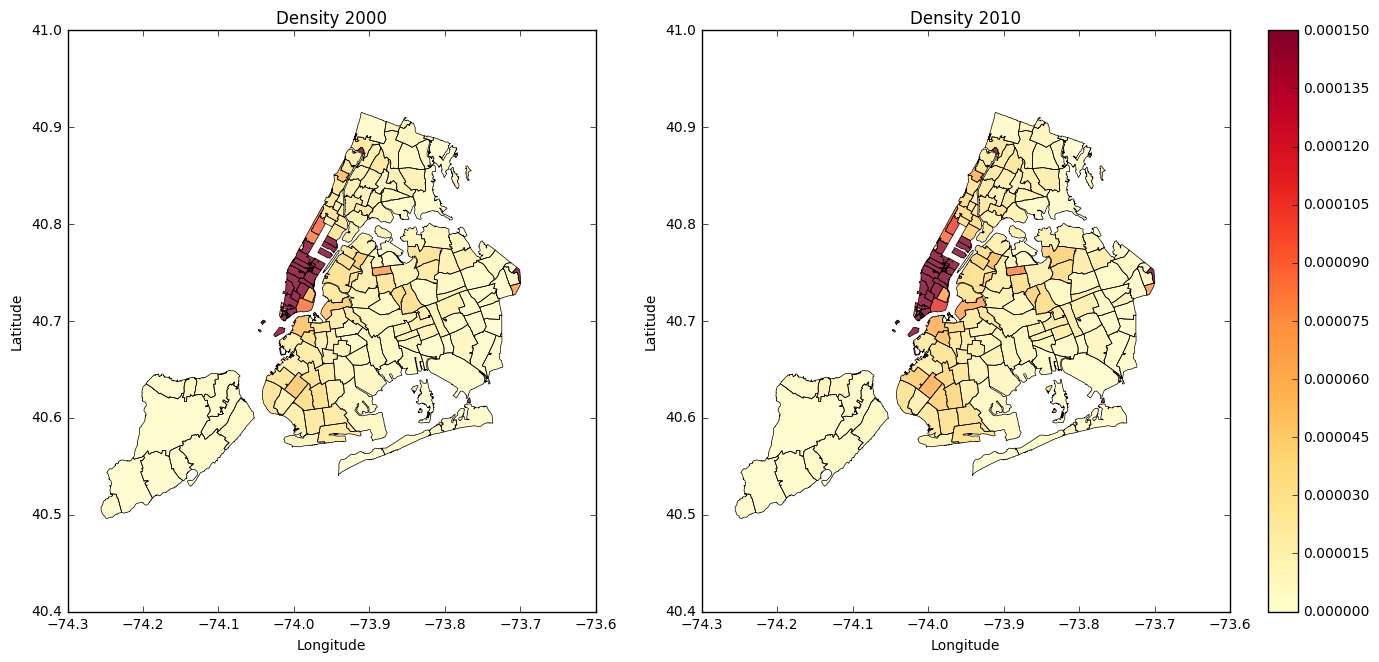

In [472]:
fig = plt.figure(figsize = (15,7.5))
plt.subplot(1,2,1)

ax = fig.add_subplot(121)
vmin=0
vmax=0.00015

# Plotting extraction (density 2000)
zipcodes.plot(alpha=0.8, linewidth=0.5, column = 'Density 2000', 
              cmap = 'YlOrRd', vmin=vmin, vmax=vmax, ax = ax)
plt.title('Density 2000')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

ax = fig.add_subplot(122)
zipcodes.plot(alpha=0.8, linewidth=0.5, column = 'Density 2010', 
              cmap = 'YlOrRd', vmin=vmin, vmax=vmax, ax = ax)
plt.title('Density 2010')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

fig = ax.get_figure()
cax = fig.add_axes([0.925, 0.125, 0.02, 0.775])
sm = plt.cm.ScalarMappable(cmap='YlOrRd', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# fake up the array of the scalar mappable. Urgh...
sm._A = []
fig.colorbar(sm, cax=cax)

#### This plot shows us that the most dense region in 2000 is south Manhattan, while the rest of NYC is facing an equal density of business (per area). In 2010, we can see that the pattern have not changed in Manhattan and some growth can be noticed in Brooklyn and Queens.

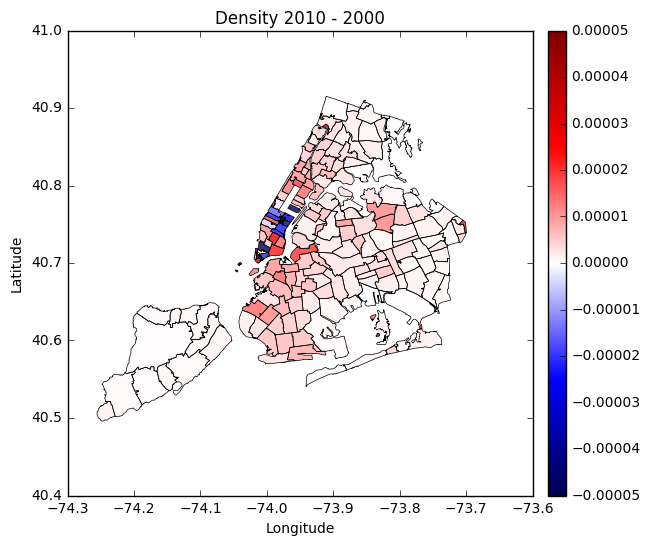

In [501]:
# For this plot I'll use a divergent colormap to show that some areas has decrease of density (blue areas)  
vmin=-0.00005
vmax=0.00005

# Plotting extraction (density 2000)
f, ax = plt.subplots(figsize=(6,6))
zipcodes.plot(alpha=0.8, linewidth=0.5, column = 'Density 2010 - 2000', 
              cmap = 'seismic', vmin=vmin, vmax=vmax, ax = ax)
plt.title('Density 2010 - 2000')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

fig = ax.get_figure()
cax = fig.add_axes([0.925, 0.125, 0.03, 0.775])
sm = plt.cm.ScalarMappable(cmap='seismic', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cax)

plt.show()

#### By this plot, we can see that some areas in south / center Manhattan has decreased the number of business from 2000 to 2010 (blue color), decreasing it's density, while other parts of Manhattan, Brooklyn and Bronx has reported an increase in business density (salmon / red color).

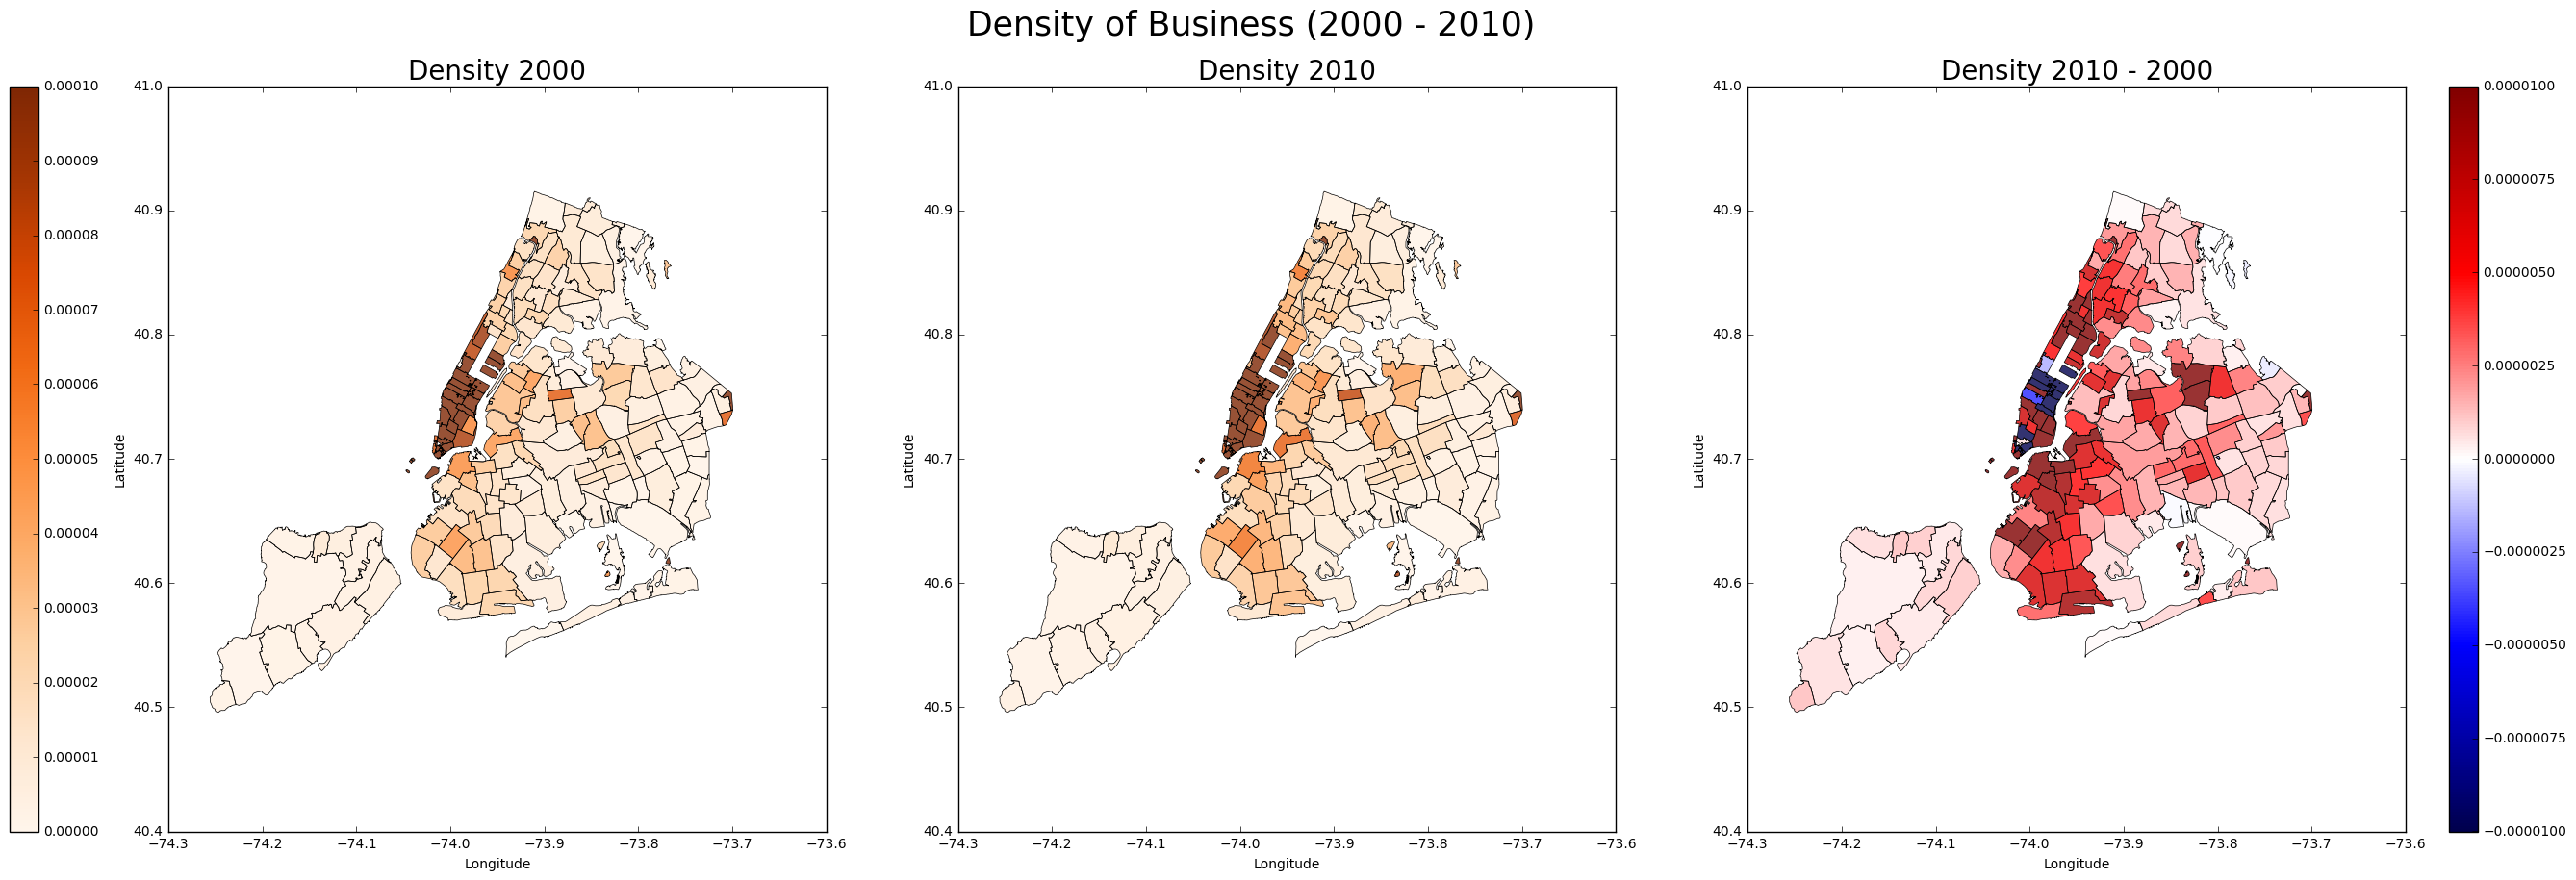

In [536]:
fig = plt.figure(figsize = (30,10))
pl.suptitle('Density of Business (2000 - 2010)', fontsize=25)
plt.subplot(1,3,1)

ax = fig.add_subplot(131)
vmin = 0.0000
vmax = 0.0001

# Plotting extraction (density 2000)
zipcodes.plot(alpha=0.8, linewidth=0.5, column = 'Density 2000', 
              cmap = 'Oranges', vmin=vmin, vmax=vmax, ax = ax)
plt.title('Density 2000', fontsize = 20)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

ax = fig.add_subplot(132)
zipcodes.plot(alpha=0.8, linewidth=0.5, column = 'Density 2010', 
              cmap = 'Oranges', vmin=vmin, vmax=vmax, ax = ax)
plt.title('Density 2010', fontsize = 20)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

fig = ax.get_figure()
cax = fig.add_axes([0.07, 0.125, 0.01, 0.775])
sm = plt.cm.ScalarMappable(cmap='Oranges', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cax)

vmin = -0.00001
vmax = 0.00001

ax = fig.add_subplot(133)
zipcodes.plot(alpha=0.8, linewidth=0.5, column = 'Density 2010 - 2000', 
              cmap = 'seismic', vmin=vmin, vmax=vmax, ax = ax)
plt.title('Density 2010 - 2000', fontsize = 20)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

fig = ax.get_figure()
cax = fig.add_axes([0.915, 0.125, 0.01, 0.775])
sm = plt.cm.ScalarMappable(cmap='seismic', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cax)

**This plot shows us that the most dense region in 2000 is south Manhattan, while the rest of NYC is facing an equal density of business (per area). In 2010, we can see that the pattern have not changed in Manhattan and some growth can be noticed in Brooklyn and Queens.
It's also interesting to see that some areas in south / center Manhattan has decreased the number of business from 2000 to 2010 (blue color), decreasing it's density, while other parts of Manhattan, Brooklyn and Bronx has reported an increase in business density (salmon / red color).**

#### 4 - Collect census data from the 2010 and 2000 census and extract the estimate (mean or median) age, population, and diversity of each census tract for all 5 NYC boroughs. The diversity (or lack thereof) can be measured by the fraction of white population.

#### 5 - Collect the income data by census tract from the income from American Fact Finder for the years 2010 and 2000 at the census tract level.

#### 6 - Merge the datasets for each year and show a the tables containing the relevant data: the features and whatever else you need to identify and plot the data.

In [21]:
%matplotlib inline

import ast
import json
import urllib
import urllib2
from cStringIO import StringIO


SQL_SOURCE = 'https://fb55.cartodb.com/api/v2/sql'

def queryCartoDB(query, format='CSV', source=SQL_SOURCE):
    """queries data from CartoDB SQL database
    Arguments:
    query: a string like 
            SELECT colum_name_1, column_name_2 FROM database_name
    format: the file format (e.g. CSV, GeoJson)
    source: the sql database url link
    Return:
        database as a string to be read in with the appropriate function
    """
    data = urllib.urlencode({'format': format, 'q': query})
    try:
        response = urllib2.urlopen(source, data)
    except urllib2.HTTPError, e:
        raise ValueError('\n'.join(ast.literal_eval(e.readline())['error']))
    except Exception:
        raise
    return StringIO(response.read())

# call as:
#datastream = queryCartoDB(query, format='CSV')
#data       = pd.read_csv(database_name)


### Downloading Census Data from fb cartodb

In [465]:
# Downloading Median Household income from Income Census 2000 
query = '''
SELECT geo_id, the_geom, hc01_vc64
FROM dec_00_sf3_dp3_with_ann
'''
datastream = queryCartoDB(query, format='GeoJSON')
datageo  = json.loads(datastream.read())
housInc2000 = gpd.GeoDataFrame.from_features(datageo['features'])

In [471]:
# Downloading Median Household income from Income Census 2010 
query = '''
SELECT geo_id, the_geom, hc01_est_vc13
FROM acs_10_5yr_s1901_with_ann
'''
datastream = queryCartoDB(query, format='GeoJSON')
datageo  = json.loads(datastream.read())
housInc2010 = gpd.GeoDataFrame.from_features(datageo['features'])

In [482]:
# Downloading total population, % of white population and median age (2000)
query = '''
SELECT geo_id, the_geom, hc01_vc01, hc02_vc29, hc01_vc18
FROM dec_00_sf1_dp1
'''
datastream = queryCartoDB(query, format='GeoJSON')
datageo  = json.loads(datastream.read())
popAge2000 = gpd.GeoDataFrame.from_features(datageo['features'])

In [485]:
# Downloading total population, % of white population and median age (2010)
query = '''
SELECT geo_id, the_geom, hd01_s001, hd01_s020, hd02_s078
FROM dec_10_sf1_sf1dp1
'''
datastream = queryCartoDB(query, format='GeoJSON')
datageo  = json.loads(datastream.read())
popAge2010 = gpd.GeoDataFrame.from_features(datageo['features'])

### Organizing data to merge part

In [595]:
census_2000 = pd.merge(housInc2000, popAge2000, on='geo_id', how = 'inner')
census_2000 = census_2000.drop(['geometry_x', 'geometry_y'], axis = 1)
census_2000.head()

geo_id  hc01_vc64 hc01_vc01 hc01_vc18 hc02_vc29
0  1400000US36089991900          0       988      20.4      92.8
1  1400000US36001013703      68929      2975      41.6      78.5
2  1400000US36005000200      42539      3545      32.7      32.0
3  1400000US36005002400          0         0       0.0          
4  1400000US36029001301          0         4      45.5     100.0

In [596]:
# Replacing zeros for NaN and dropping NaN
census_2000.replace({0:NaN},inplace=True)
census_2000 = census_2000.dropna()

In [597]:
census_2000.columns = [['geo_id', 'income 2000', 'population 2000', 'age 2000', 'diversity 2000']]

In [598]:
cols = census_2000.columns.tolist()
cols = [cols[0]] + cols[3:5]+ cols[1:3]
census_2000 = census_2000[cols]

In [599]:
census_2000.head()

geo_id age 2000 diversity 2000  income 2000 population 2000
1   1400000US36001013703     41.6           78.5      68929.0            2975
2   1400000US36005000200     32.7           32.0      42539.0            3545
11  1400000US36007012900     41.6           96.3      47071.0            1000
13  1400000US36015000300     33.0           30.0      21250.0            1849
15  1400000US36029940100     26.0          100.0      21250.0              10

In [652]:
census_2010 = pd.merge(housInc2010, popAge2010, on='geo_id', how = 'inner')
census_2010 = census_2010.drop(['geometry_x', 'geometry_y'], axis = 1)
census_2010.columns = [['geo_id', 'income 2010', 'population 2010', 'age 2010', 'diversity 2010']]

In [653]:
# This time, the data downloaded came with - instead of zeros
census_2010.replace({'-':NaN},inplace=True)
census_2010 = census_2010.dropna()

In [654]:
cols = census_2010.columns.tolist()
cols = [cols[0]] + cols[3:5]+ cols[1:3]
census_2010 = census_2010[cols]

In [655]:
census_2010.head()

geo_id age 2010 diversity 2010 income 2010 population 2010
0  1400000US36001000100     32.2           23.7       32333            2139
1  1400000US36001000200     28.8           13.9       25354            6046
2  1400000US36001000300     35.4           49.9       30932            5888
3  1400000US36001000401     63.7           86.3       60909            2227
4  1400000US36001000403     38.3           76.7       52807            4415

In [674]:
# I noticed that some values have different formats, all have unicode types, so let's convert it to float
# Income do not convert at first because of values like 250,000+, let's change it to a better format
l = census_2010['income 2010'].tolist()
inc = []
err = []
for i in range(0, len(l)):
    try:
        inc.append(float(l[i]))
    except:
        err.append(i)

In [675]:
for i in err:
    print(i, l[i])

951 2,500-
2277 250,000+
3831 250,000+
4646 250,000+
4691 250,000+
4708 250,000+
4709 250,000+


In [680]:
l[951] = 2500.
l[2277] = 250000.
l[3831] = 250000.
l[4646] = 250000.
l[4691] = 250000.
l[4708] = 250000.
l[4709] = 250000.

inc = []
for i in range(0, len(l)):
    try:
        inc.append(float(l[i]))
    except:
        err.append(i)

In [706]:
# Setting type for each column of this dataframe
census_2000['income 2000'] = census_2000['income 2000'].astype(float)
census_2000['age 2000'] = census_2000['age 2000'].astype(float)
census_2000['diversity 2000'] = census_2000['diversity 2000'].astype(float)
census_2000['population 2000'] = census_2000['population 2000'].astype(float)

In [681]:
# Setting type for each column of this dataframe
census_2010['income 2010'] = inc
census_2010['age 2010'] = census_2010['age 2010'].astype(float)
census_2010['diversity 2010'] = census_2010['diversity 2010'].astype(float)
census_2010['population 2010'] = census_2010['population 2010'].astype(float)

In [683]:
merged = pd.merge(census_2000, census_2010, how='inner', on='geo_id')

In [687]:
cen = list(merged['geo_id'])
ct = []
boro = []

for i in range(0, len(cen)):
    ct.append(cen[i][14:])
    boro.append(cen[i][11:14])

merged['CT'] = ct
merged['Boro'] = boro

### Here is the merged dataset, containing information from 2000 and 2010

In [688]:
merged.head()

geo_id age 2000 diversity 2000  income 2000 population 2000  \
0  1400000US36001013703     41.6           78.5      68929.0            2975   
1  1400000US36005000200     32.7           32.0      42539.0            3545   
2  1400000US36007012900     41.6           96.3      47071.0            1000   
3  1400000US36029940100     26.0          100.0      21250.0              10   
4  1400000US36047070201     43.8           96.1      67986.0            6502   

   age 2010  diversity 2010  income 2010  population 2010      CT Boro  
0      42.9            76.2      90135.0           2500.0  013703  001  
1      33.9            30.7      59826.0           4334.0  000200  005  
2      59.8            98.2      58523.0           1532.0  012900  007  
3      19.5             0.0       2500.0             34.0  940100  029  
4      42.8            95.2      79278.0           6573.0  070201  047

### 7 - Merge the df with the census tracts shapefile (see DATA and HINTS files) and display each of your features as a choropleth for both 2010 and 2000, and show the difference in the features as a third choroplath.


### Downloading Census Tracts Shapefile

In [694]:
# Downloading Census Tracts Shapefile
query = '''
SELECT *
FROM table_2010_census_tracts
'''
datastream = queryCartoDB(query, format='GeoJSON')
datageo  = json.loads(datastream.read())
ct_shape = gpd.GeoDataFrame.from_features(datageo['features'])

In [695]:
# Transforming its coordinates
from fiona.crs import from_epsg
ct_shape.crs = from_epsg(4326) 

In [696]:
ct_shape.crs

{'init': 'epsg:4326', 'no_defs': True}

In [697]:
ct_shape = ct_shape[['boro_code', 'boro_ct_2010', 'ct_2010', 'geometry', 'shape_area']]

In [698]:
ct_shape.head(3)

boro_code boro_ct_2010 ct_2010  \
0         3      3050804  050804   
1         3      3027500  027500   
2         2      2009200  009200   

                                            geometry     shape_area  
0  (POLYGON ((-73.96140699999999 40.65217, -73.96...  1110945.63082  
1  (POLYGON ((-73.935008 40.682764, -73.937932 40...  1743574.56294  
2  (POLYGON ((-73.847279 40.829315, -73.847320999...  3278193.62083

In [699]:
ct_shape.columns

Index([u'boro_code', u'boro_ct_2010', u'ct_2010', u'geometry', u'shape_area'], dtype='object')

In [ ]:
# Do not run, just for reference
'''countyID = {'Bronx':'005',
           'Manhattan':'061',
           'Staten Island':'085',
           'Brooklyn':'047',
           'Queens':'081'}
'''

In [700]:
Boro = {'061': '1',
        '005': '2',
        '047': '3',
        '081': '4',
        '085': '5'
        }

### Selecting just information inside NYC boroughs

In [29]:
nycMerged = merged.loc[merged['Boro'].isin(['005','061', '085', '047', '081'])]

In [30]:
nycMerged = nycMerged.replace({"Boro": Boro})
nycMerged['boro_ct_2010'] = nycMerged['Boro'] + nycMerged['CT']

In [31]:
nycMerged.head()

geo_id  age 2000  diversity 2000  income 2000  \
137  1400000US36047000100      37.5            75.3      63333.0   
138  1400000US36047000200      25.3            33.5      29219.0   
139  1400000US36047000301      38.7            84.1      83739.0   
140  1400000US36047000700      35.2            82.4      66213.0   
141  1400000US36047000900      34.6            78.2      79201.0   

     population 2000  age 2010  diversity 2010  income 2010  population 2010  \
137             5260      43.7            78.3      85396.0             4338   
138             1303      25.8            36.1      54688.0             1470   
139             5036      40.7            85.9     160833.0             4259   
140             3682      34.9            85.9     129097.0             3359   
141             2178      33.0            72.3      97385.0             4172   

         CT Boro boro_ct_2010  
137  000100    3      3000100  
138  000200    3      3000200  
139  000301    3      3000301  
140  000700    3      3000700  
141  000900    3      3000900

In [689]:
nycMerged.shape

(1877, 12)

### Let's merge the datasets on the common column: boro_ct_2010. 

In [32]:
# To this, we need to change the name of the column to make it compatible
nyc_shape = pd.merge(ct_shape, nycMerged, on = 'boro_ct_2010')

In [33]:
nyc_shape.drop(['CT', 'Boro'], inplace=True, axis=1)

In [34]:
nyc_shape['age 2010-2000'] = nyc_shape['age 2010'] - nyc_shape['age 2000']
nyc_shape['diversity 2010-2000'] = nyc_shape['diversity 2010'] - nyc_shape['diversity 2000']
nyc_shape['pop 2010-2000'] = nyc_shape['population 2010'] - nyc_shape['population 2000']
nyc_shape['income 2010-2000'] = nyc_shape['income 2010'] - nyc_shape['income 2000']

In [35]:
nyc_shape.head(3)

boro_code boro_ct_2010 ct_2010  \
0         3      3027500  027500   
1         2      2009200  009200   
2         4      4099100  099100   

                                            geometry     shape_area  \
0  (POLYGON ((-73.935008 40.682764, -73.937932 40...  1743574.56294   
1  (POLYGON ((-73.847279 40.829315, -73.847320999...  3278193.62083   
2  (POLYGON ((-73.791793 40.789352, -73.791563999...  11557974.9909   

                 geo_id  age 2000  diversity 2000  income 2000  \
0  1400000US36047027500      33.9             1.5      30241.0   
1  1400000US36005009200      31.7            30.1      36589.0   
2  1400000US36081099100      47.1            87.7      62341.0   

   population 2000  age 2010  diversity 2010  income 2010  population 2010  \
0             4171      35.6             9.1      52958.0             4180   
1             4877      33.3            29.5      45625.0             5017   
2             6659      51.1            85.5      84350.0             6507   

   age 2010-2000  diversity 2010-2000  pop 2010-2000  income 2010-2000  
0            1.7                  7.6              9           22717.0  
1            1.6                 -0.6            140            9036.0  
2            4.0                 -2.2           -152           22009.0

In [36]:
# This function takes the data and plot the choroplets of 2000, 2010 and the difference between those years
def three_maps(data, column1, column2, column3, cmap1, cmap2, suptitle):

    fig = plt.figure(figsize = (30,10))
    pl.suptitle(suptitle, fontsize=25)
    plt.subplot(1,3,1)

    ax = fig.add_subplot(131)
    vmin = (data[column1].mean() + data[column2].mean()) / 2 \
    - (data[column1].std() + data[column2].std())/2
    vmax = (data[column1].mean() + data[column2].mean()) / 2 \
    + (data[column1].std() + data[column2].std())/2

    # Plotting extraction (density 2000)
    data.plot(alpha=0.8, linewidth=0.5, column = column1, 
                  cmap = cmap1, vmin=vmin, vmax=vmax, ax = ax)
    plt.title(column1, fontsize = 20)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    ax = fig.add_subplot(132)
    data.plot(alpha=0.8, linewidth=0.5, column = column2, 
                  cmap = cmap1, vmin=vmin, vmax=vmax, ax = ax)
    plt.title(column2, fontsize = 20)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    fig = ax.get_figure()
    cax = fig.add_axes([0.07, 0.125, 0.01, 0.775])
    sm = plt.cm.ScalarMappable(cmap=cmap1, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    fig.colorbar(sm, cax=cax)

    vmin = data[column3].mean() - data[column3].std()
    vmax = data[column3].mean() + data[column3].std()
    
    ax = fig.add_subplot(133)
    data.plot(alpha=0.8, linewidth=0.5, column = column3, 
                  cmap = cmap2, vmin=vmin, vmax=vmax, ax = ax)
    plt.title(column3, fontsize = 20)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    fig = ax.get_figure()
    cax = fig.add_axes([0.915, 0.125, 0.01, 0.775])
    sm = plt.cm.ScalarMappable(cmap=cmap2, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    fig.colorbar(sm, cax=cax)

### Plotting choropleths for Age, Population, Diversity and Income

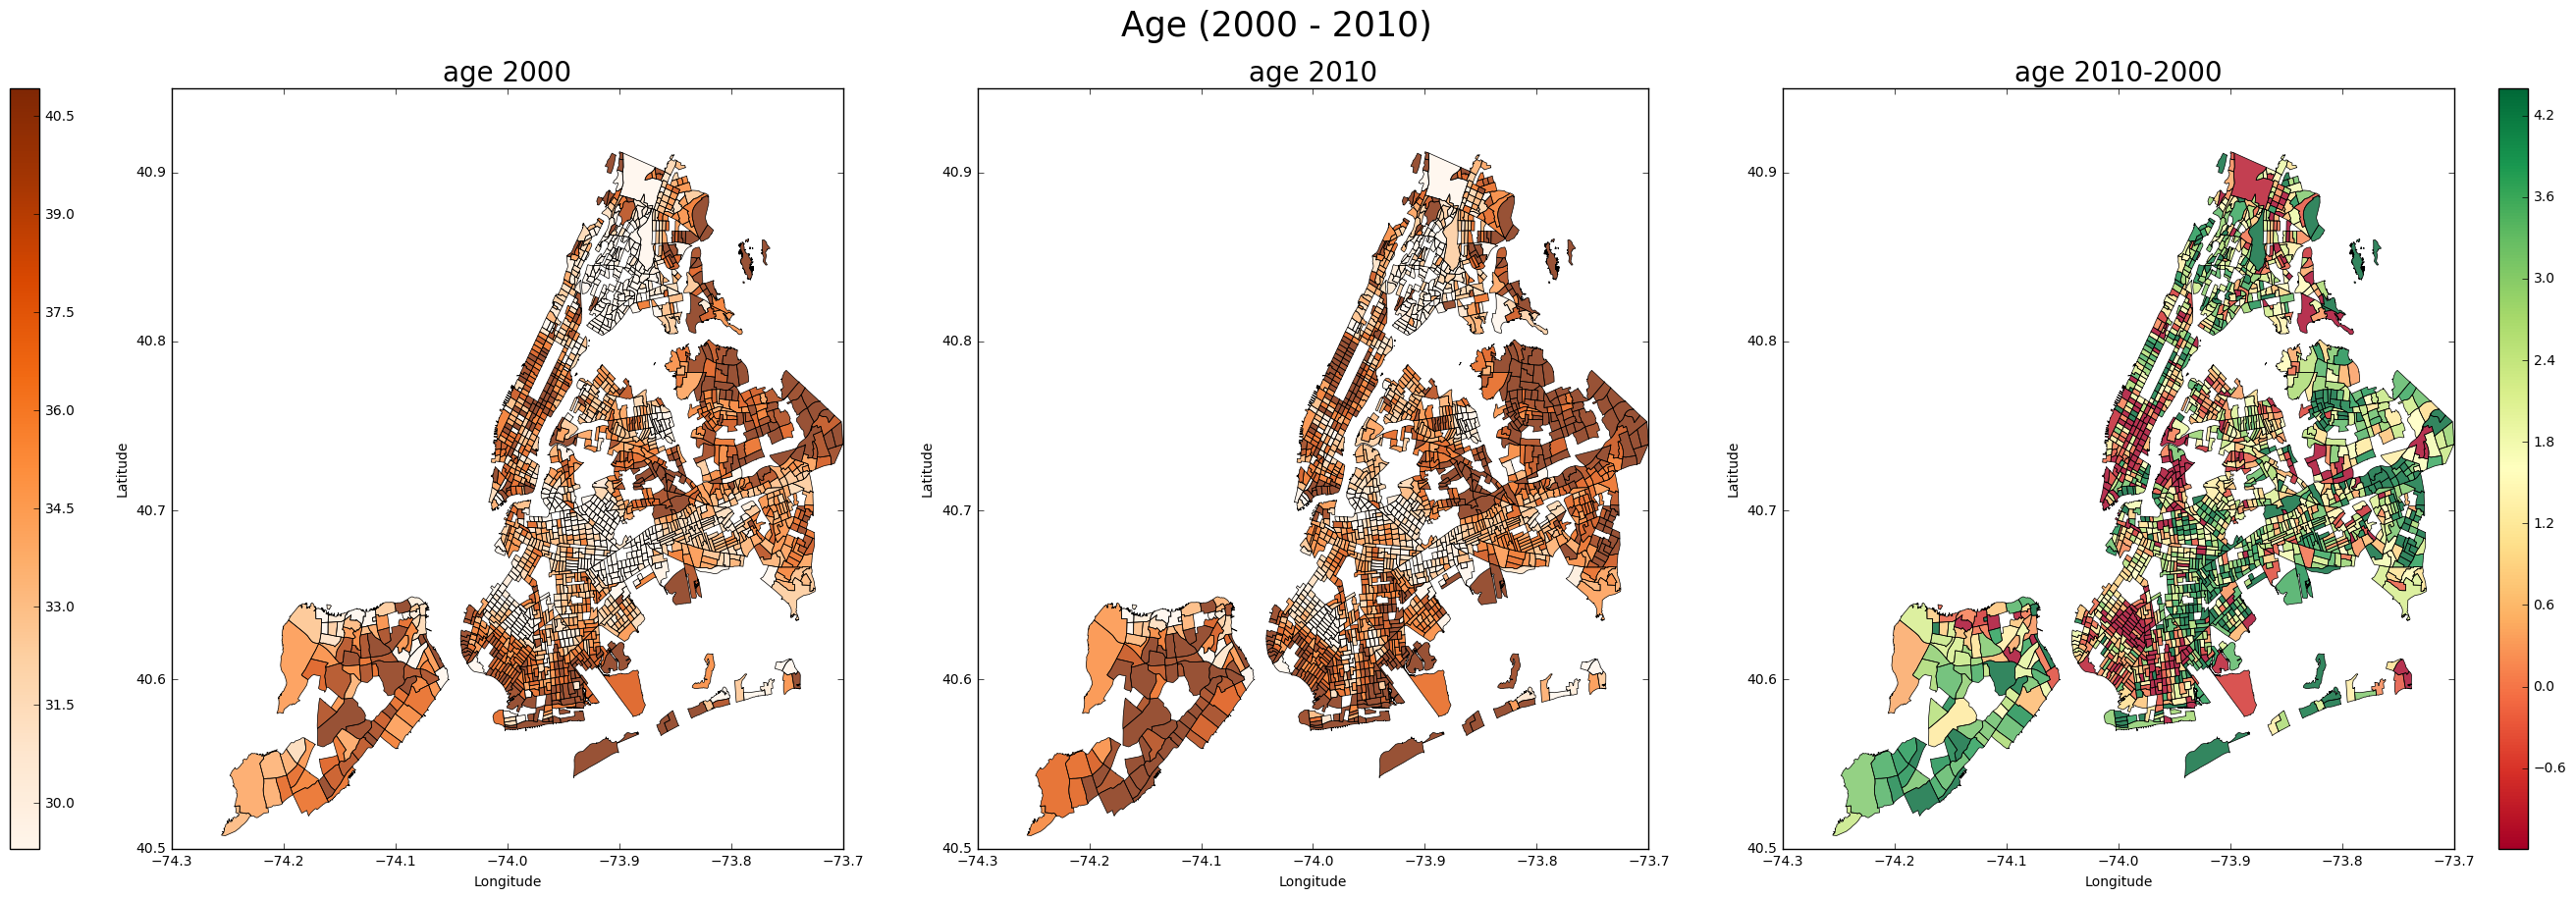

In [526]:
three_maps(nyc_shape, 'age 2000', 'age 2010', 'age 2010-2000', 'Oranges', 'RdYlGn', 'Age (2000 - 2010)')

By those plots we can notice an increase in population's age from 2000 to 2010 in east Brooklyn, Staten Island and mid Manhattan (see areas being darkened from map 2000 to 2010). One interesting observation is that mid-south Manhattan and south Brooklyn population average has become younger (red regions) while the rest of NYC older (green areas).

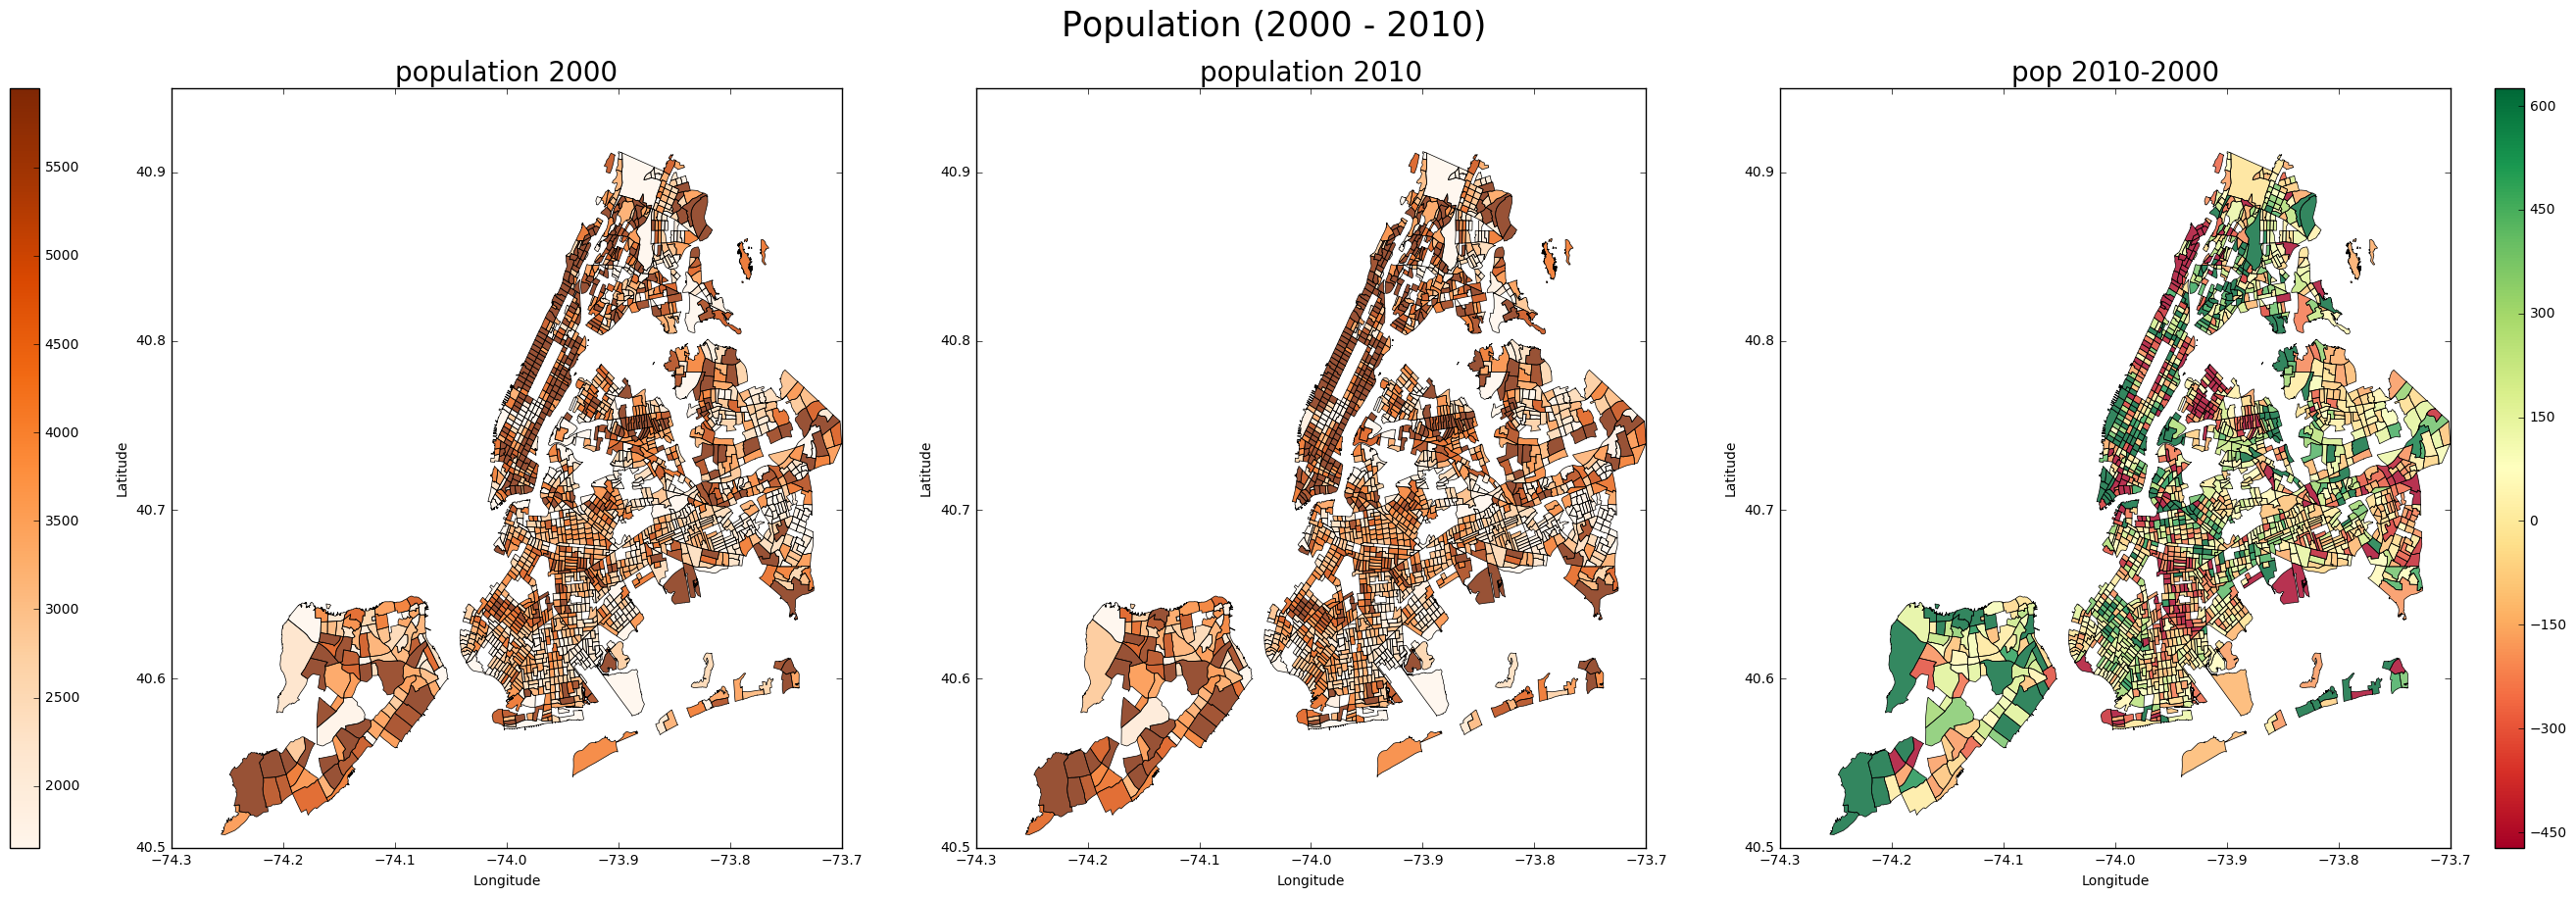

In [527]:
three_maps(nyc_shape, 'population 2000', 'population 2010', 'pop 2010-2000', 'Oranges', 'RdYlGn',
                      'Population (2000 - 2010)')

Population has increased in mid-south Manhattan, central Brooklyn and Staten Island. There were a great reduction in population on Queens and east Brooklyn.

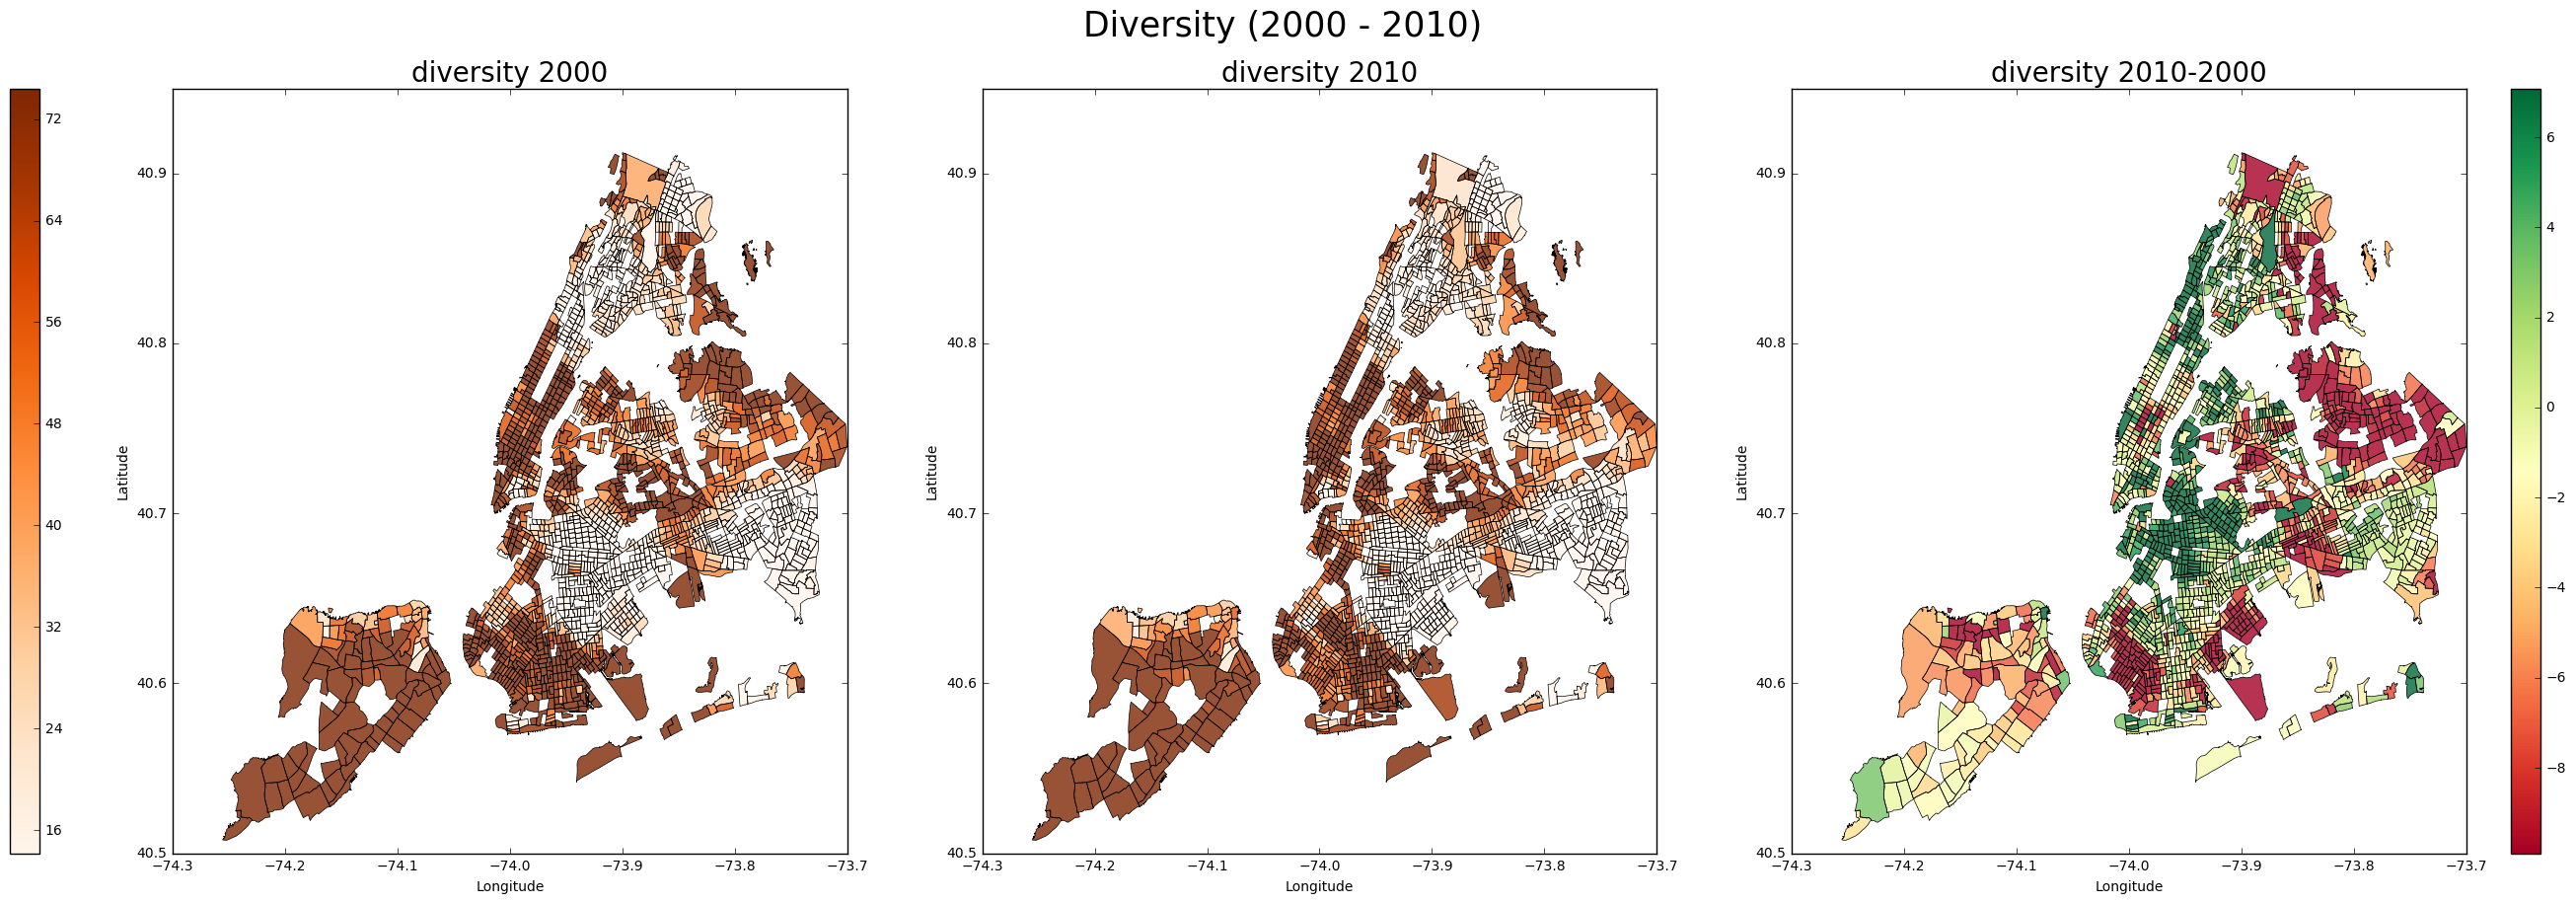

In [528]:
three_maps(nyc_shape, 'diversity 2000', 'diversity 2010', 'diversity 2010-2000', 'Oranges', 'RdYlGn',
                      'Diversity (2000 - 2010)')

New York is definitely a diverse city. We see a high percentage of diversity in all boroughs besides Bronx. The areas in Brooklyn that have less diversity increased it's diversity considerably from 2000 to 2010 (see green areas on map).
In addition, the areas we observe reduction in diversity are already very diversified areas, they faced a reduction in percentage but they are still much diverse than many cities in US.

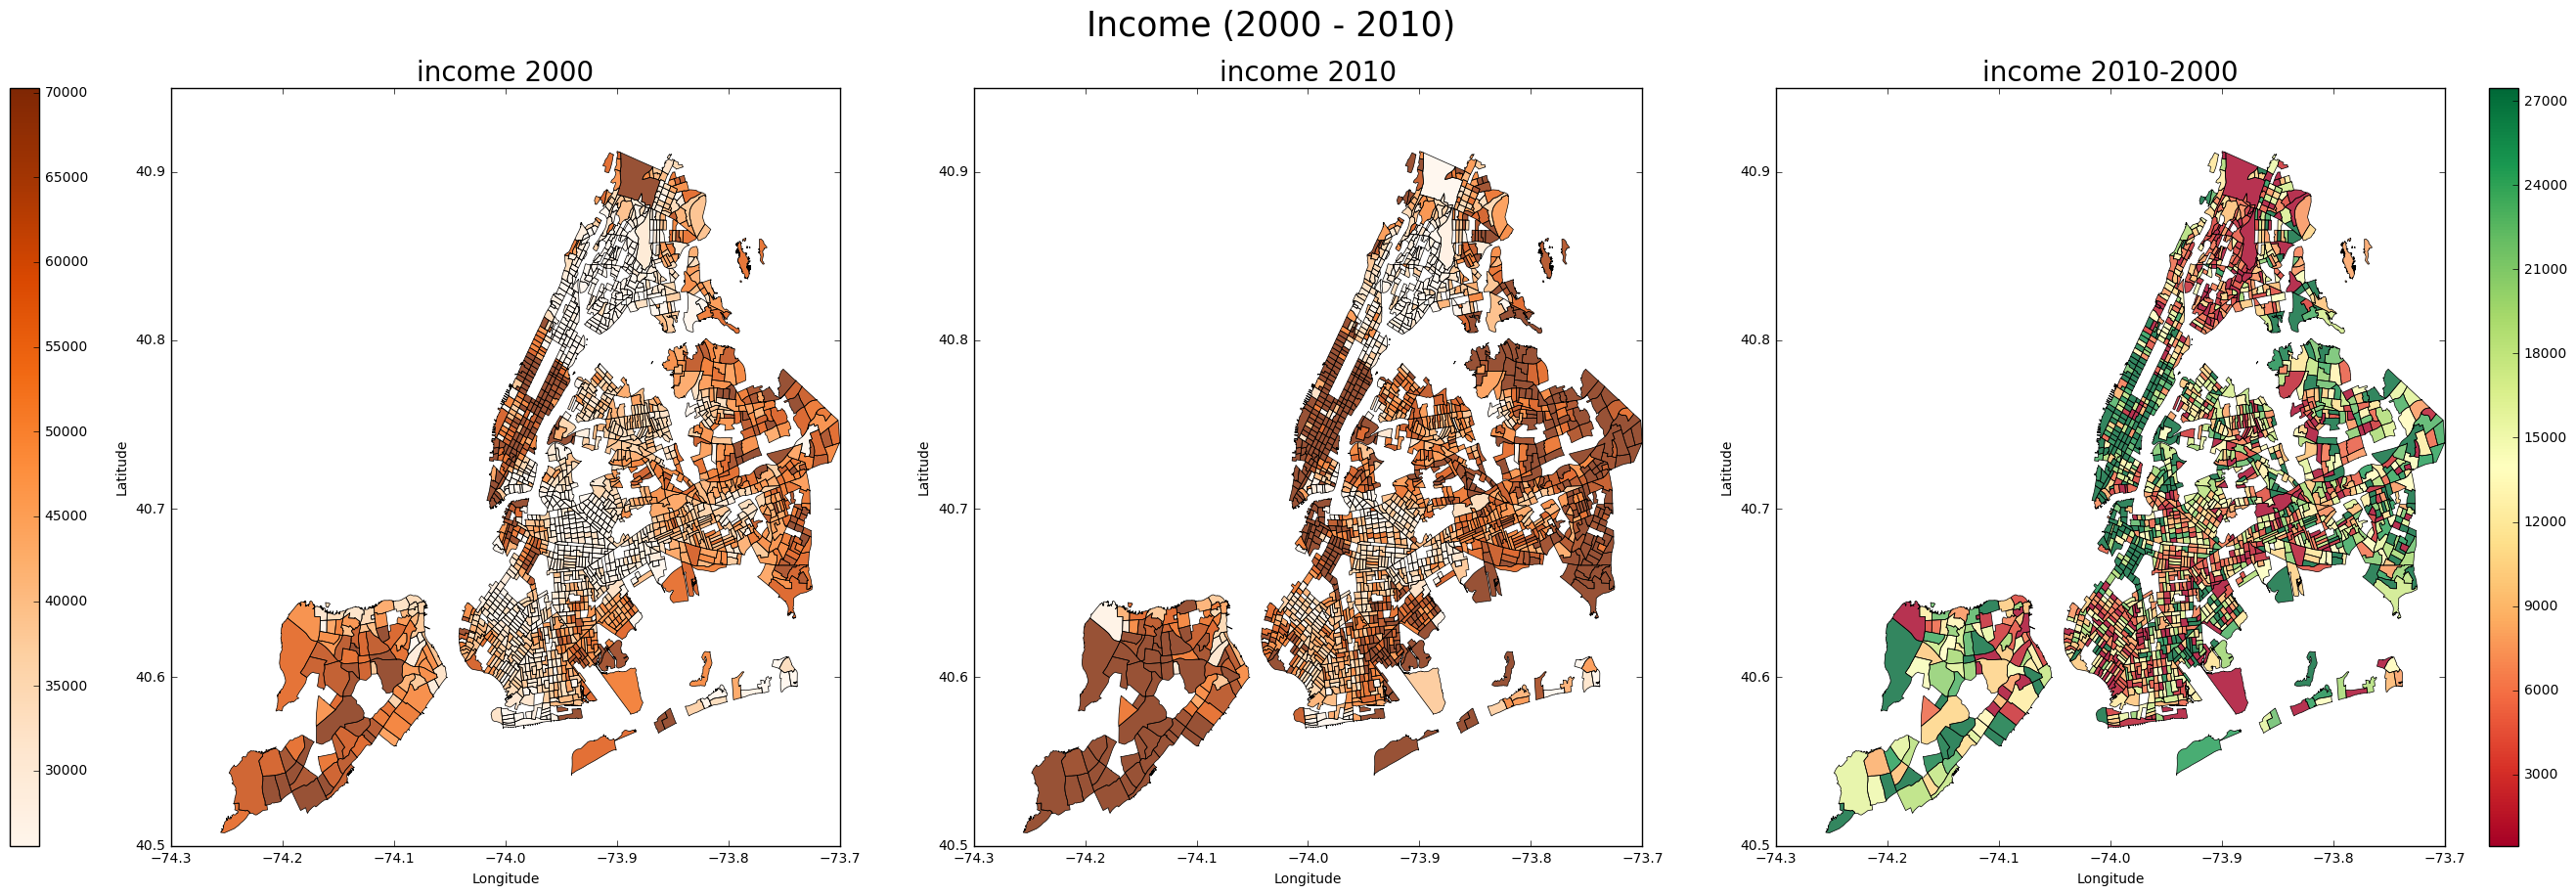

In [529]:
three_maps(nyc_shape, 'income 2000', 'income 2010', 'income 2010-2000', 'Oranges', 'RdYlGn', 
                      'Income (2000 - 2010)')

**Manhattan, north and east of Brooklyn and Staten Island increased it's income in this 10 years gap. Bronx and south Brooklyn are preocupant points, since they've been always low income areas and has decreased its income from 2000 to 2010.**

### 8 - (OPTIONAL) Cluster the census tracts on these four features (using a Eucledian distance)

### 9 - (OPTIONAL) Identify the census tracts that have changed cluster assignment (those that are now associated with a different group of census tracts) and show a choropleth of the clusters in 2010, 2000 and a choropleth of the cluster changes. (Once you get through this, you have done most of the heavy lifting! The rest is building upon this work.)

### Our data has no NaN values, we checked before. So now before clustering we have to whitening the data (by rows)

In [386]:
cluster_2000 = nyc_shape.iloc[:,6:10]
cluster_2010 = nyc_shape.iloc[:,10:14]
cluster_2000 = (cluster_2000 - cluster_2000.mean()) / cluster_2000.std()
cluster_2010 = (cluster_2010 - cluster_2010.mean()) / cluster_2010.std()

### Checking if whitening worked on our data (we want mean ~ 0 and std ~ 1 on each column)

In [388]:
cluster_2000.head()

age 2000  diversity 2000  income 2000  population 2000
0 -0.072741       -1.409671    -0.569317         0.188869
1 -0.455874       -0.482849    -0.231919         0.515631
2  2.226056        1.383756     1.136806         1.340403
3  1.215979        0.337031     2.388866        -1.107534
4  0.327807       -1.121255    -1.618556        -1.017743

In [389]:
print ("i expect means of each col to be = 0", cluster_2000.mean()[:5])
print ("i expect stds of each col to be = 1", cluster_2000.std()[:5])

print ("i expect means of each col to be = 0", cluster_2010.mean(0)[:5])
print ("i expect stds of each col to be = 1", cluster_2010.std(0)[:5])


i expect means of each col to be = 0 age 2000           8.341756e-15
diversity 2000    -3.018777e-15
income 2000        1.233253e-16
population 2000   -8.606151e-17
dtype: float64
i expect stds of each col to be = 1 age 2000           1.0
diversity 2000     1.0
income 2000        1.0
population 2000    1.0
dtype: float64
i expect means of each col to be = 0 age 2010          -6.080438e-15
diversity 2010    -9.892637e-16
income 2010       -1.230887e-16
population 2010   -1.082423e-16
dtype: float64
i expect stds of each col to be = 1 age 2010           1.0
diversity 2010     1.0
income 2010        1.0
population 2010    1.0
dtype: float64


### Let's cluster using K-Means

In [390]:
clusters = nyc_shape.copy()

In [391]:
# Clustering for 2000
n_clusters = 5
X=np.asarray(cluster_2000)
km = KMeans(n_clusters=n_clusters, random_state=324)
cluster_labels = km.fit_predict(X)
clusters['cluster_2000'] = cluster_labels

In [392]:
# Saving cluster centers to init 2010 clustering
centers = km.cluster_centers_

In [393]:
# Initializing clustering to 2010 data with centers obtained on 2000 clustering
X=np.asarray(cluster_2010)
km = KMeans(n_clusters=n_clusters, random_state=324, init=centers)
cluster_labels = km.fit_predict(X)
clusters['cluster_2010'] = cluster_labels

In [394]:
# Creating column on dataframe that indicates which CT has changed clusters
c2000 = clusters['cluster_2000'].tolist()
c2010 = clusters['cluster_2010'].tolist()
clusterChange = clusters['cluster_2000'] - clusters['cluster_2010']
for i in range(0, len(clusterChange)):
    if clusterChange[i] != 0:
        clusterChange[i] = str(c2000[i]) + ' to ' + str(c2010[i])
    else:
        clusterChange[i] = 'Not changed'

In [395]:
# We want to check if there are just 0 and 1 (1 means that the cluster has changed from 2000 to 2010)
set(clusterChange)

{'0 to 1',
 '0 to 2',
 '0 to 4',
 '1 to 0',
 '1 to 2',
 '1 to 3',
 '1 to 4',
 '2 to 0',
 '2 to 1',
 '2 to 3',
 '2 to 4',
 '3 to 1',
 '3 to 2',
 '3 to 4',
 '4 to 0',
 '4 to 1',
 '4 to 2',
 '4 to 3',
 'Not changed'}

In [396]:
clusters['Cluster_Change'] = clusterChange

In [397]:
clusters.head()

boro_code boro_ct_2010 ct_2010  \
0         3      3027500  027500   
1         2      2009200  009200   
2         4      4099100  099100   
3         4      4000100  000100   
4         3      3024100  024100   

                                            geometry     shape_area  \
0  (POLYGON ((-73.935008 40.682764, -73.937932 40...  1743574.56294   
1  (POLYGON ((-73.847279 40.829315, -73.847320999...  3278193.62083   
2  (POLYGON ((-73.791793 40.789352, -73.791563999...  11557974.9909   
3  (POLYGON ((-73.949113 40.754524, -73.949144 40...  12286326.8522   
4  (POLYGON ((-73.951465 40.689863, -73.955122 40...  1939949.84007   

                 geo_id  age 2000  diversity 2000  income 2000  \
0  1400000US36047027500      33.9             1.5      30241.0   
1  1400000US36005009200      31.7            30.1      36589.0   
2  1400000US36081099100      47.1            87.7      62341.0   
3  1400000US36081000100      41.3            55.4      85898.0   
4  1400000US36047024100      36.2            10.4      10500.0   

   population 2000       ...        diversity 2010  income 2010  \
0             4171       ...                   9.1      52958.0   
1             4877       ...                  29.5      45625.0   
2             6659       ...                  85.5      84350.0   
3             1370       ...                  63.5     117750.0   
4             1564       ...                  43.7      39861.0   

   population 2010  age 2010-2000  diversity 2010-2000  pop 2010-2000  \
0             4180            1.7                  7.6              9   
1             5017            1.6                 -0.6            140   
2             6507            4.0                 -2.2           -152   
3             4949           -8.9                  8.1           3579   
4             2229           -4.9                 33.3            665   

   income 2010-2000  cluster_2000  cluster_2010  Cluster_Change  
0           22717.0             0             4          0 to 4  
1            9036.0             0             0     Not changed  
2           22009.0             3             3     Not changed  
3           31852.0             3             3     Not changed  
4           29361.0             0             0     Not changed  

[5 rows x 21 columns]

### Plotting the choropleth of the clusters in 2010, 2000 and a choropleth of the cluster changes

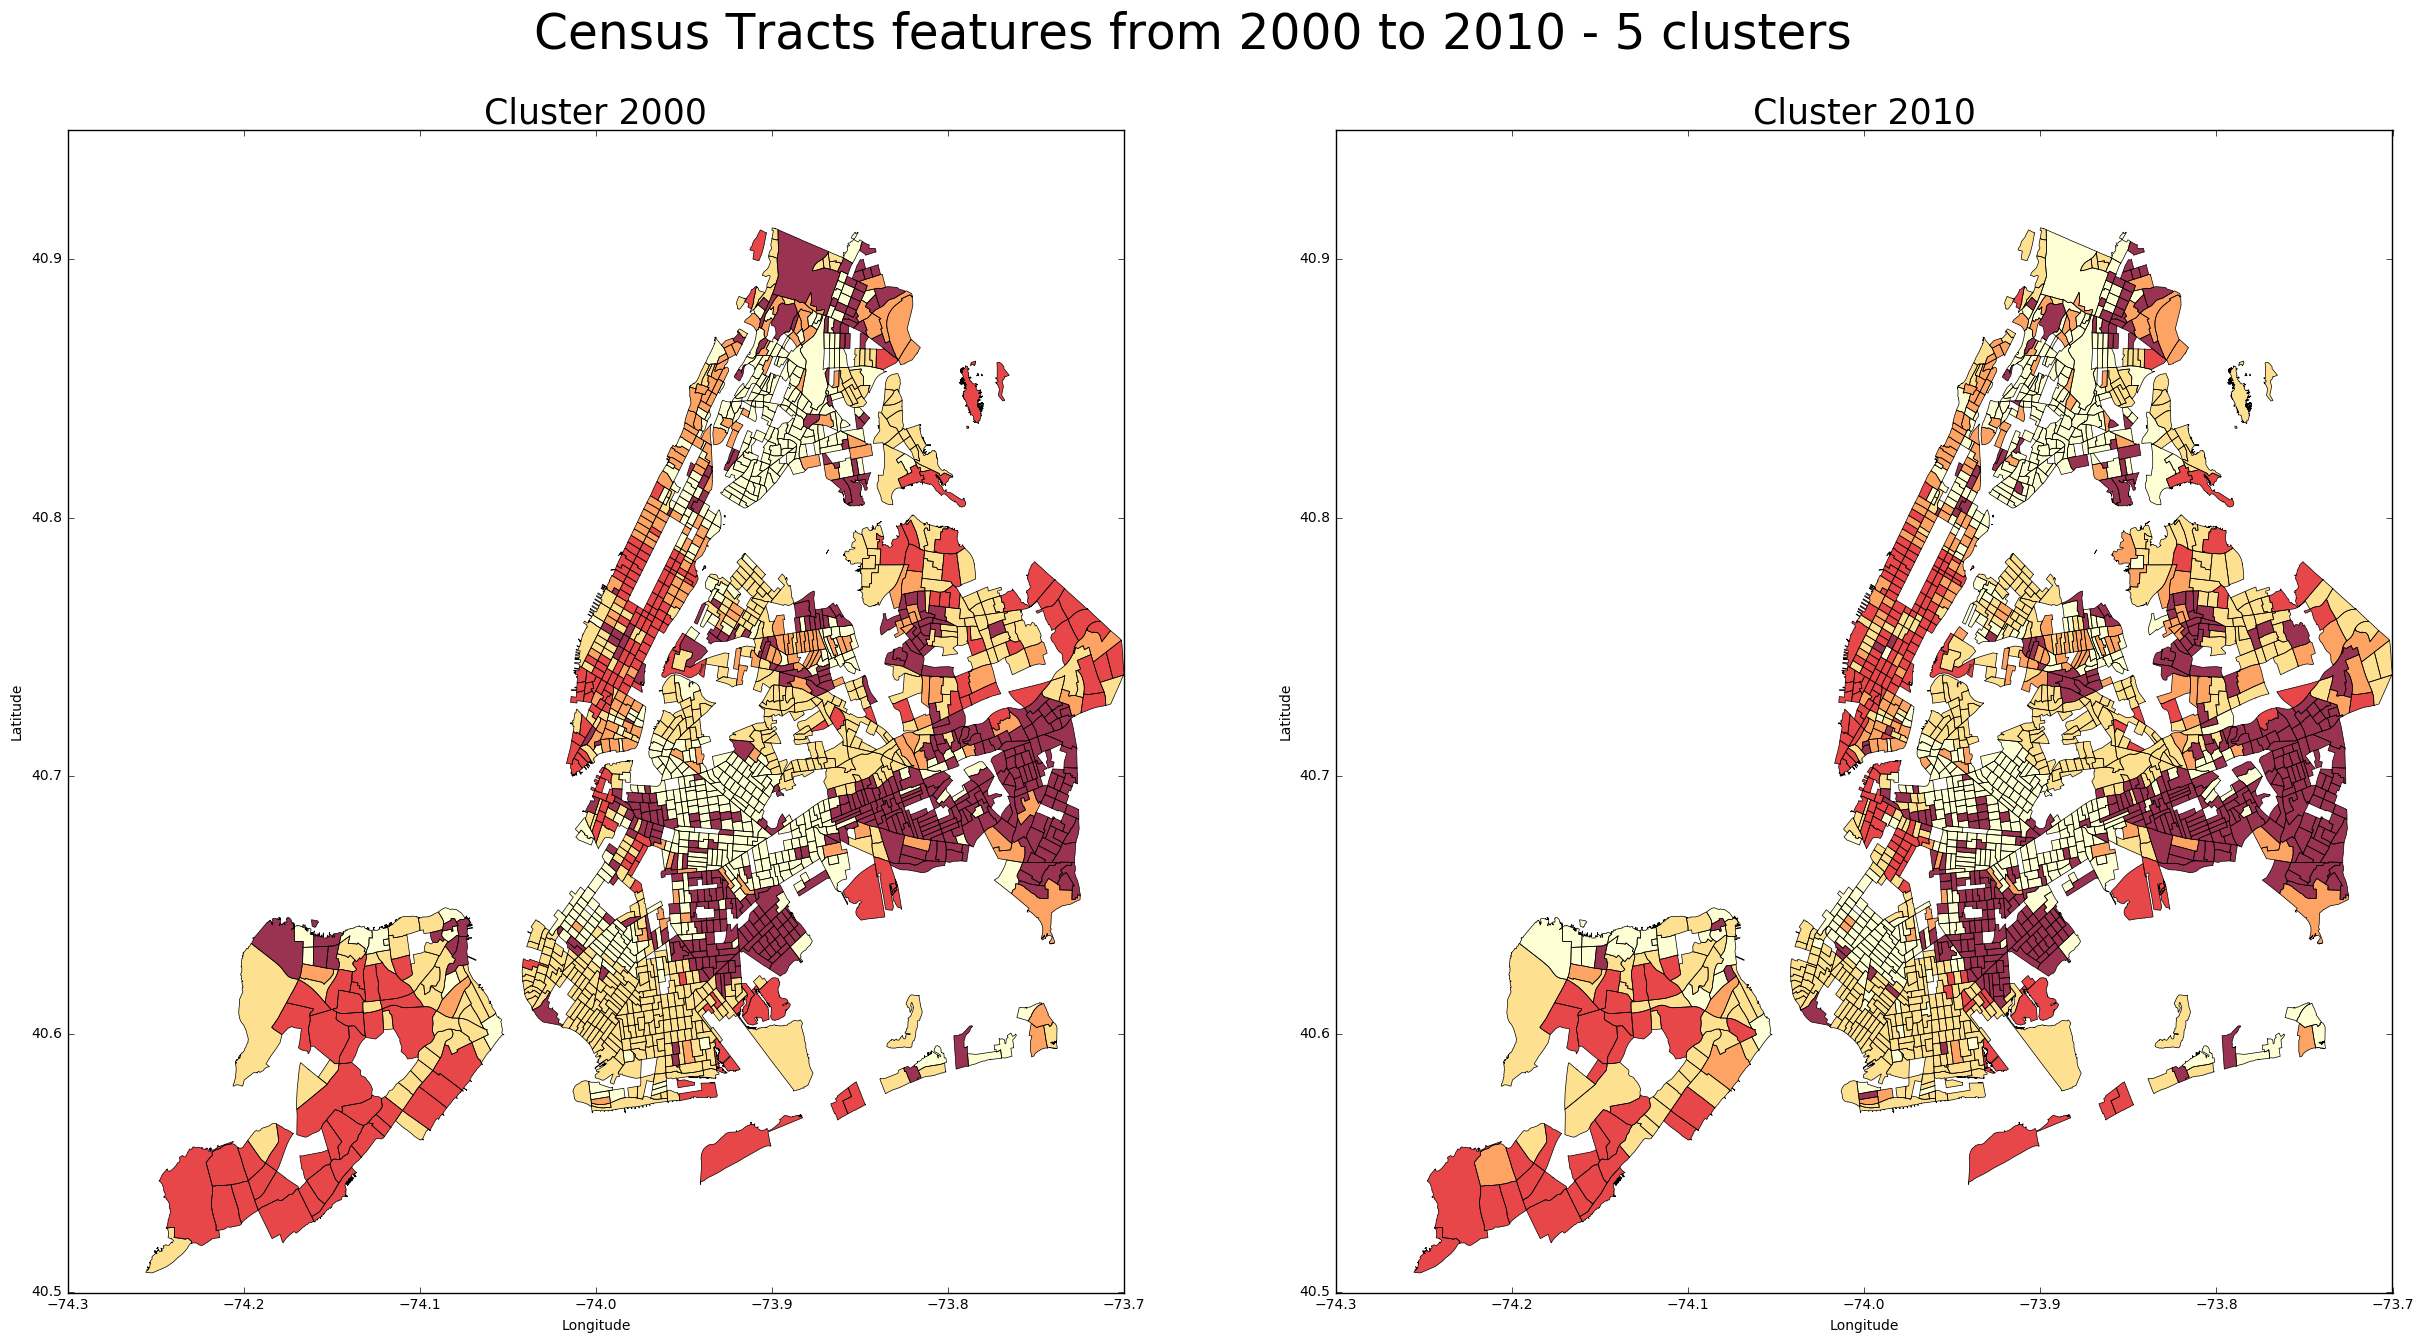

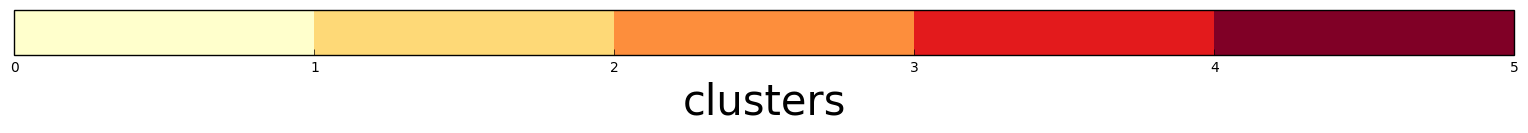

In [398]:
fig = plt.figure(figsize = (30,15))
pl.suptitle('Census Tracts features from 2000 to 2010 - 5 clusters', fontsize=35)
plt.subplot(1,2,1)

ax = fig.add_subplot(121)
cmap = mpl.cm.YlOrRd

clusters.plot(alpha=0.8, linewidth=0.5, column = 'cluster_2000', cmap = cmap, ax = ax)
plt.title('Cluster 2000', fontsize = 25)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

ax = fig.add_subplot(122)
clusters.plot(alpha=0.8, linewidth=0.5, column = 'cluster_2010', cmap = cmap, ax = ax)
plt.title('Cluster 2010', fontsize = 25)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

fig = pl.figure(figsize=(15, 3))
ax1 = fig.add_axes([0.05, 1.0, 1, 0.15])
norm = mpl.colors.Normalize(vmin=0, vmax=5)
nc = n_clusters

bounds = range(nc + 1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb3 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                norm=norm,
                                ticks=bounds,
                                spacing='uniform',
                                orientation='horizontal')
cb3.set_label('clusters', fontsize=30)


We noticed by the plots that most of CTs are clustered around cluster 0 and 3, indicating that 5 clusters can be too many to diferentiate the characteristics choosen to make this study. However, the positive side of using 5 clusters is that it can make us have insights about small changes that could be generalized by choose of less clusters. 
To analyse the meaning of those clusters, let's take a look in how those changed from 2000 ti 2010 in the next plot.

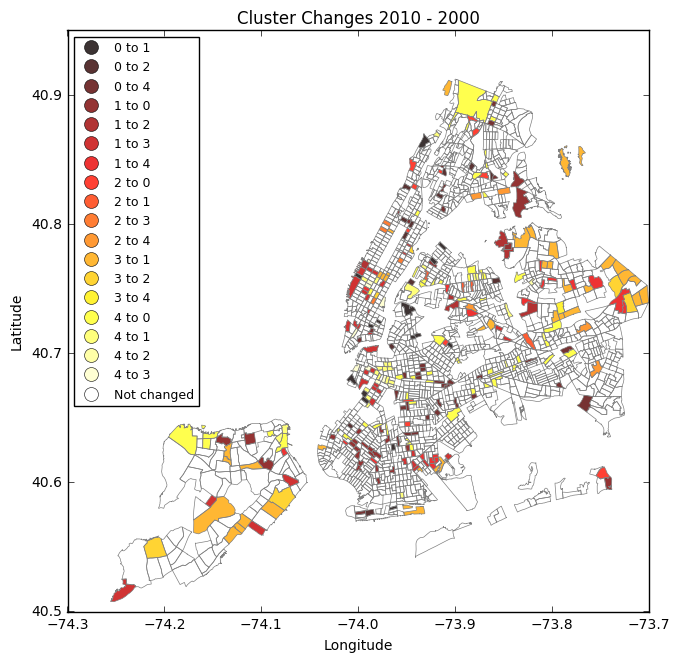

In [407]:
f, ax = plt.subplots(figsize=(7.5, 7.5))

params = {'legend.fontsize': 9}
plt.rcParams.update(params)

clusters.plot(alpha=0.8, linewidth=0.5, column = 'Cluster_Change', 
              cmap = 'hot', categorical=True, ax = ax, edgecolor='grey', legend=True)
plt.title('Cluster Changes 2010 - 2000')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

We notice that most of changes happen outside of Manhattan, and by that we can hypothesize that Manhattan has not changed so much its characteristics in these 10 years, unlikely Brooklyn and Bronx which have changed considerably.

In [408]:
print('Changes in MH:',len(clusters[(clusters['boro_code'] == '1') & (clusters['Cluster_Change'] != 'Not changed')]))
print('Changes in BX:', len(clusters[(clusters['boro_code'] == '2') & (clusters['Cluster_Change'] != 'Not changed')]))
print('Changes in BK:',len(clusters[(clusters['boro_code'] == '3') & (clusters['Cluster_Change'] != 'Not changed')]))
print('Changes in QU:',len(clusters[(clusters['boro_code'] == '4') & (clusters['Cluster_Change'] != 'Not changed')]))
print('Changes in S.I.:',len(clusters[(clusters['boro_code'] == '5') & (clusters['Cluster_Change'] != 'Not changed')]))
print('There were %d cluster changes (2000 - 2010).' %len(clusters[clusters['Cluster_Change'] != 'Not changed']))

Changes in MH: 53
Changes in BX: 30
Changes in BK: 113
Changes in QU: 91
Changes in S.I.: 25
There were 312 cluster changes (2000 - 2010).


10 - Aggregate the census four features at the zipcode level and merge the zipcode dataframe

### Preparing data to merge - we want to obtain a data on zipcodes level 

In [409]:
# Checking coordinates format
zipcodes.crs == nyc_shape.crs

True

In [410]:
# Checking centroid format
nyc_shape.geometry.centroid.head()

0    POINT (-73.93817849385184 40.68389708695573)
1    POINT (-73.85210982299243 40.83235742729679)
2    POINT (-73.80002157849106 40.79030242380239)
3    POINT (-73.95065299870262 40.74321286156224)
4    POINT (-73.95380379679214 40.69222179804105)
dtype: object

In [411]:
# Code obtained from prof. Kashuk - it returns a list with zipcodes of each CT centroids
a=[]
for i in range(len(nyc_shape)):
    try:
        a.append(zipcodes[zipcodes.geometry.intersects(nyc_shape.iloc[i].geometry.centroid)].zip.values[0])
    except IndexError:
        a.append(0)
    print ('\r', '%',str((i+1)*100./len(nyc_shape)))

 % 0.0532765050613
 % 0.106553010123
 % 0.159829515184
 % 0.213106020245
 % 0.266382525306
 % 0.319659030368
 % 0.372935535429
 % 0.42621204049
 % 0.479488545551
 % 0.532765050613
 % 0.586041555674
 % 0.639318060735
 % 0.692594565796
 % 0.745871070858
 % 0.799147575919
 % 0.85242408098
 % 0.905700586042
 % 0.958977091103
 % 1.01225359616
 % 1.06553010123
 % 1.11880660629
 % 1.17208311135
 % 1.22535961641
 % 1.27863612147
 % 1.33191262653
 % 1.38518913159
 % 1.43846563665
 % 1.49174214172
 % 1.54501864678
 % 1.59829515184
 % 1.6515716569
 % 1.70484816196
 % 1.75812466702
 % 1.81140117208
 % 1.86467767714
 % 1.91795418221
 % 1.97123068727
 % 2.02450719233
 % 2.07778369739
 % 2.13106020245
 % 2.18433670751
 % 2.23761321257
 % 2.29088971763
 % 2.3441662227
 % 2.39744272776
 % 2.45071923282
 % 2.50399573788
 % 2.55727224294
 % 2.610548748
 % 2.66382525306
 % 2.71710175812
 % 2.77037826319
 % 2.82365476825
 % 2.87693127331
 % 2.93020777837
 % 2.98348428343
 % 3.03676078849
 % 3.09003729355
 

In [412]:
test_nyc = nyc_shape.copy()
test_nyc['zip'] = a

In [413]:
# We have more than 1 CTs on some zipcodes. Let's make each zipcode an unique row and the values 
# will be the mean of all CTS on this zipcode
ctToZip = pd.DataFrame()
uniqueZip = test_nyc['zip'].unique()

for zc in uniqueZip:
    #print(zc)
    ctToZip = ctToZip.append(pd.DataFrame(test_nyc[test_nyc['zip'] == zc].mean()).T)

In [414]:
# Getting read of the differences calculated for step #3. After the mean, they lost its real values
ctToZip = ctToZip.drop(ctToZip.columns[[8, 9, 10, 11]], axis=1)

In [415]:
ctToZip['zip'] = ctToZip['zip'].astype(int)
ctToZip.head()

age 2000  diversity 2000   income 2000  population 2000   age 2010  \
0  30.020000        4.570000  23960.500000      3339.900000  32.640000   
0  33.392308       44.830769  35335.153846      3071.615385  34.753846   
0  41.366667       83.166667  55704.666667      4136.333333  43.944444   
0  34.000000       47.662500  38897.125000      2611.375000  34.600000   
0  30.944444       25.788889  31876.888889      3088.444444  31.400000   

   diversity 2010   income 2010  population 2010    zip  
0        6.245000  36689.750000      3557.000000  11233  
0       39.784615  47439.384615      3354.307692  10462  
0       76.666667  76475.222222      4051.333333  11357  
0       49.575000  54749.875000      3232.875000  11101  
0       45.488889  52948.777778      3239.666667  11205

### Merging the data to obtain zipcodes level information

In [416]:
zipLevel = pd.merge(zipcodes, ctToZip, on = 'zip', how = 'inner')

In [417]:
zipLevel.head(3)

zip                                           geometry          area  \
0  11436  POLYGON ((-73.80584847647386 40.6829093264758,...  2.269930e+07   
1  11213  POLYGON ((-73.93739763139808 40.67972958928417...  2.963100e+07   
2  11212  POLYGON ((-73.90294132545432 40.6708397759334,...  4.197210e+07   

   2000  2010  Density 2000  Density 2010  Density 2010 - 2000   age 2000  \
0    65    98      0.000003      0.000004             0.000001  33.250000   
1   477   675      0.000016      0.000023             0.000007  29.600000   
2   520   699      0.000012      0.000017             0.000004  28.427778   

   diversity 2000   income 2000  population 2000   age 2010  diversity 2010  \
0        1.630000  40976.600000      2061.700000  35.080000        3.640000   
1       14.368750  26933.437500      3965.812500  31.875000       21.056250   
2        3.683333  22683.777778      4426.388889  31.827778        4.655556   

    income 2010  population 2010  
0  62520.000000      1993.300000  
1  35751.812500      3843.437500  
2  28106.333333      4353.666667

In [418]:
# Checking any NaN values
zipLevel.isnull().values.any()

False

11 - Repeat steps 7,8,9 at the zipcode level (NOT OPTIONAL AT THE ZIPCODE LEVEL) with the added feature (density of businesses).

### Now it's time to cluster on Zipcodes level, but first we have to whiten the data

In [419]:
clusterZip_2000 = zipLevel.iloc[:,[5,8,9,10,11]]
clusterZip_2010 = zipLevel.iloc[:,[6,12,13,14,15]]

In [420]:
clusterZip_2000 = (clusterZip_2000 - clusterZip_2000.mean()) / clusterZip_2000.std()
clusterZip_2010 = (clusterZip_2010 - clusterZip_2010.mean()) / clusterZip_2010.std()

In [421]:
print ("i expect means of each col to be = 0", clusterZip_2000.mean()[:5])
print ("i expect stds of each col to be = 1", clusterZip_2000.std()[:5])

print ("i expect means of each col to be = 0", cluster_2010.mean()[:5])
print ("i expect stds of each col to be = 1", cluster_2010.std()[:5])

i expect means of each col to be = 0 Density 2000      -2.297119e-16
age 2000          -1.748141e-15
diversity 2000    -7.667286e-17
income 2000        4.203973e-16
population 2000    1.387472e-15
dtype: float64
i expect stds of each col to be = 1 Density 2000       1.0
age 2000           1.0
diversity 2000     1.0
income 2000        1.0
population 2000    1.0
dtype: float64
i expect means of each col to be = 0 age 2010          -6.080438e-15
diversity 2010    -9.892637e-16
income 2010       -1.230887e-16
population 2010   -1.082423e-16
dtype: float64
i expect stds of each col to be = 1 age 2010           1.0
diversity 2010     1.0
income 2010        1.0
population 2010    1.0
dtype: float64


In [422]:
clusterZip_2010.head(2)

Density 2010  age 2010  diversity 2010  income 2010  population 2010
0     -0.376872 -0.275395       -1.719792      0.09893        -1.281921
1     -0.296708 -0.854350       -1.041935     -1.00804        -0.182819

### Now with whitened data, we can cluster using K-Means

In [423]:
# Clustering data from 2000 census
n_clusters = 5
X=np.asarray(clusterZip_2000)
km = KMeans(n_clusters=n_clusters, random_state=324)
cluster_labels = km.fit_predict(X)
zipLevel['cluster_2000'] = cluster_labels

In [424]:
# Saving cluster centers to init 2010 clustering
centers = km.cluster_centers_

In [425]:
# Initializing clustering to 2010 data with centers obtained on 2000 clustering
X=np.asarray(clusterZip_2010)
km = KMeans(n_clusters=n_clusters, random_state=324, init=centers)
cluster_labels = km.fit_predict(X)
zipLevel['cluster_2010'] = cluster_labels

In [426]:
zipLevel.head(3)

zip                                           geometry          area  \
0  11436  POLYGON ((-73.80584847647386 40.6829093264758,...  2.269930e+07   
1  11213  POLYGON ((-73.93739763139808 40.67972958928417...  2.963100e+07   
2  11212  POLYGON ((-73.90294132545432 40.6708397759334,...  4.197210e+07   

   2000  2010  Density 2000  Density 2010  Density 2010 - 2000   age 2000  \
0    65    98      0.000003      0.000004             0.000001  33.250000   
1   477   675      0.000016      0.000023             0.000007  29.600000   
2   520   699      0.000012      0.000017             0.000004  28.427778   

   diversity 2000   income 2000  population 2000   age 2010  diversity 2010  \
0        1.630000  40976.600000      2061.700000  35.080000        3.640000   
1       14.368750  26933.437500      3965.812500  31.875000       21.056250   
2        3.683333  22683.777778      4426.388889  31.827778        4.655556   

    income 2010  population 2010  cluster_2000  cluster_2010  
0  62520.000000      1993.300000             1             1  
1  35751.812500      3843.437500             1             1  
2  28106.333333      4353.666667             1             1

In [427]:
# Creating column on dataframe that indicates which CT has changed clusters
c2000 = zipLevel['cluster_2000'].tolist()
c2010 = zipLevel['cluster_2010'].tolist()
clusterChange = zipLevel['cluster_2000'] - zipLevel['cluster_2010']
for i in range(0, len(clusterChange)):
    if clusterChange[i] != 0:
        clusterChange[i] = str(c2000[i]) + ' to ' + str(c2010[i])
    else:
        clusterChange[i] = 'Not changed'

In [428]:
# We want to check if there are just 0 and 1 (1 means that the cluster has changed from 2000 to 2010)
set(clusterChange)

{'0 to 2',
 '1 to 2',
 '2 to 0',
 '2 to 1',
 '3 to 2',
 '4 to 0',
 '4 to 2',
 'Not changed'}

In [429]:
zipLevel['Cluster_Change'] = clusterChange

In [430]:
zipLevel.head(3)

zip                                           geometry          area  \
0  11436  POLYGON ((-73.80584847647386 40.6829093264758,...  2.269930e+07   
1  11213  POLYGON ((-73.93739763139808 40.67972958928417...  2.963100e+07   
2  11212  POLYGON ((-73.90294132545432 40.6708397759334,...  4.197210e+07   

   2000  2010  Density 2000  Density 2010  Density 2010 - 2000   age 2000  \
0    65    98      0.000003      0.000004             0.000001  33.250000   
1   477   675      0.000016      0.000023             0.000007  29.600000   
2   520   699      0.000012      0.000017             0.000004  28.427778   

   diversity 2000   income 2000  population 2000   age 2010  diversity 2010  \
0        1.630000  40976.600000      2061.700000  35.080000        3.640000   
1       14.368750  26933.437500      3965.812500  31.875000       21.056250   
2        3.683333  22683.777778      4426.388889  31.827778        4.655556   

    income 2010  population 2010  cluster_2000  cluster_2010 Cluster_Change  
0  62520.000000      1993.300000             1             1    Not changed  
1  35751.812500      3843.437500             1             1    Not changed  
2  28106.333333      4353.666667             1             1    Not changed

In [431]:
zipLevel.columns

Index([u'zip', u'geometry', u'area', u'2000', u'2010', u'Density 2000',
       u'Density 2010', u'Density 2010 - 2000', u'age 2000', u'diversity 2000',
       u'income 2000', u'population 2000', u'age 2010', u'diversity 2010',
       u'income 2010', u'population 2010', u'cluster_2000', u'cluster_2010',
       u'Cluster_Change'],
      dtype='object')

In [432]:
zipLevel.crs = from_epsg(4326) 

In [433]:
zipLevel.crs

{'init': 'epsg:4326', 'no_defs': True}

### Plotting the choropleth of the clusters in 2010, 2000 and a choropleth of the cluster changes - Zipcode level

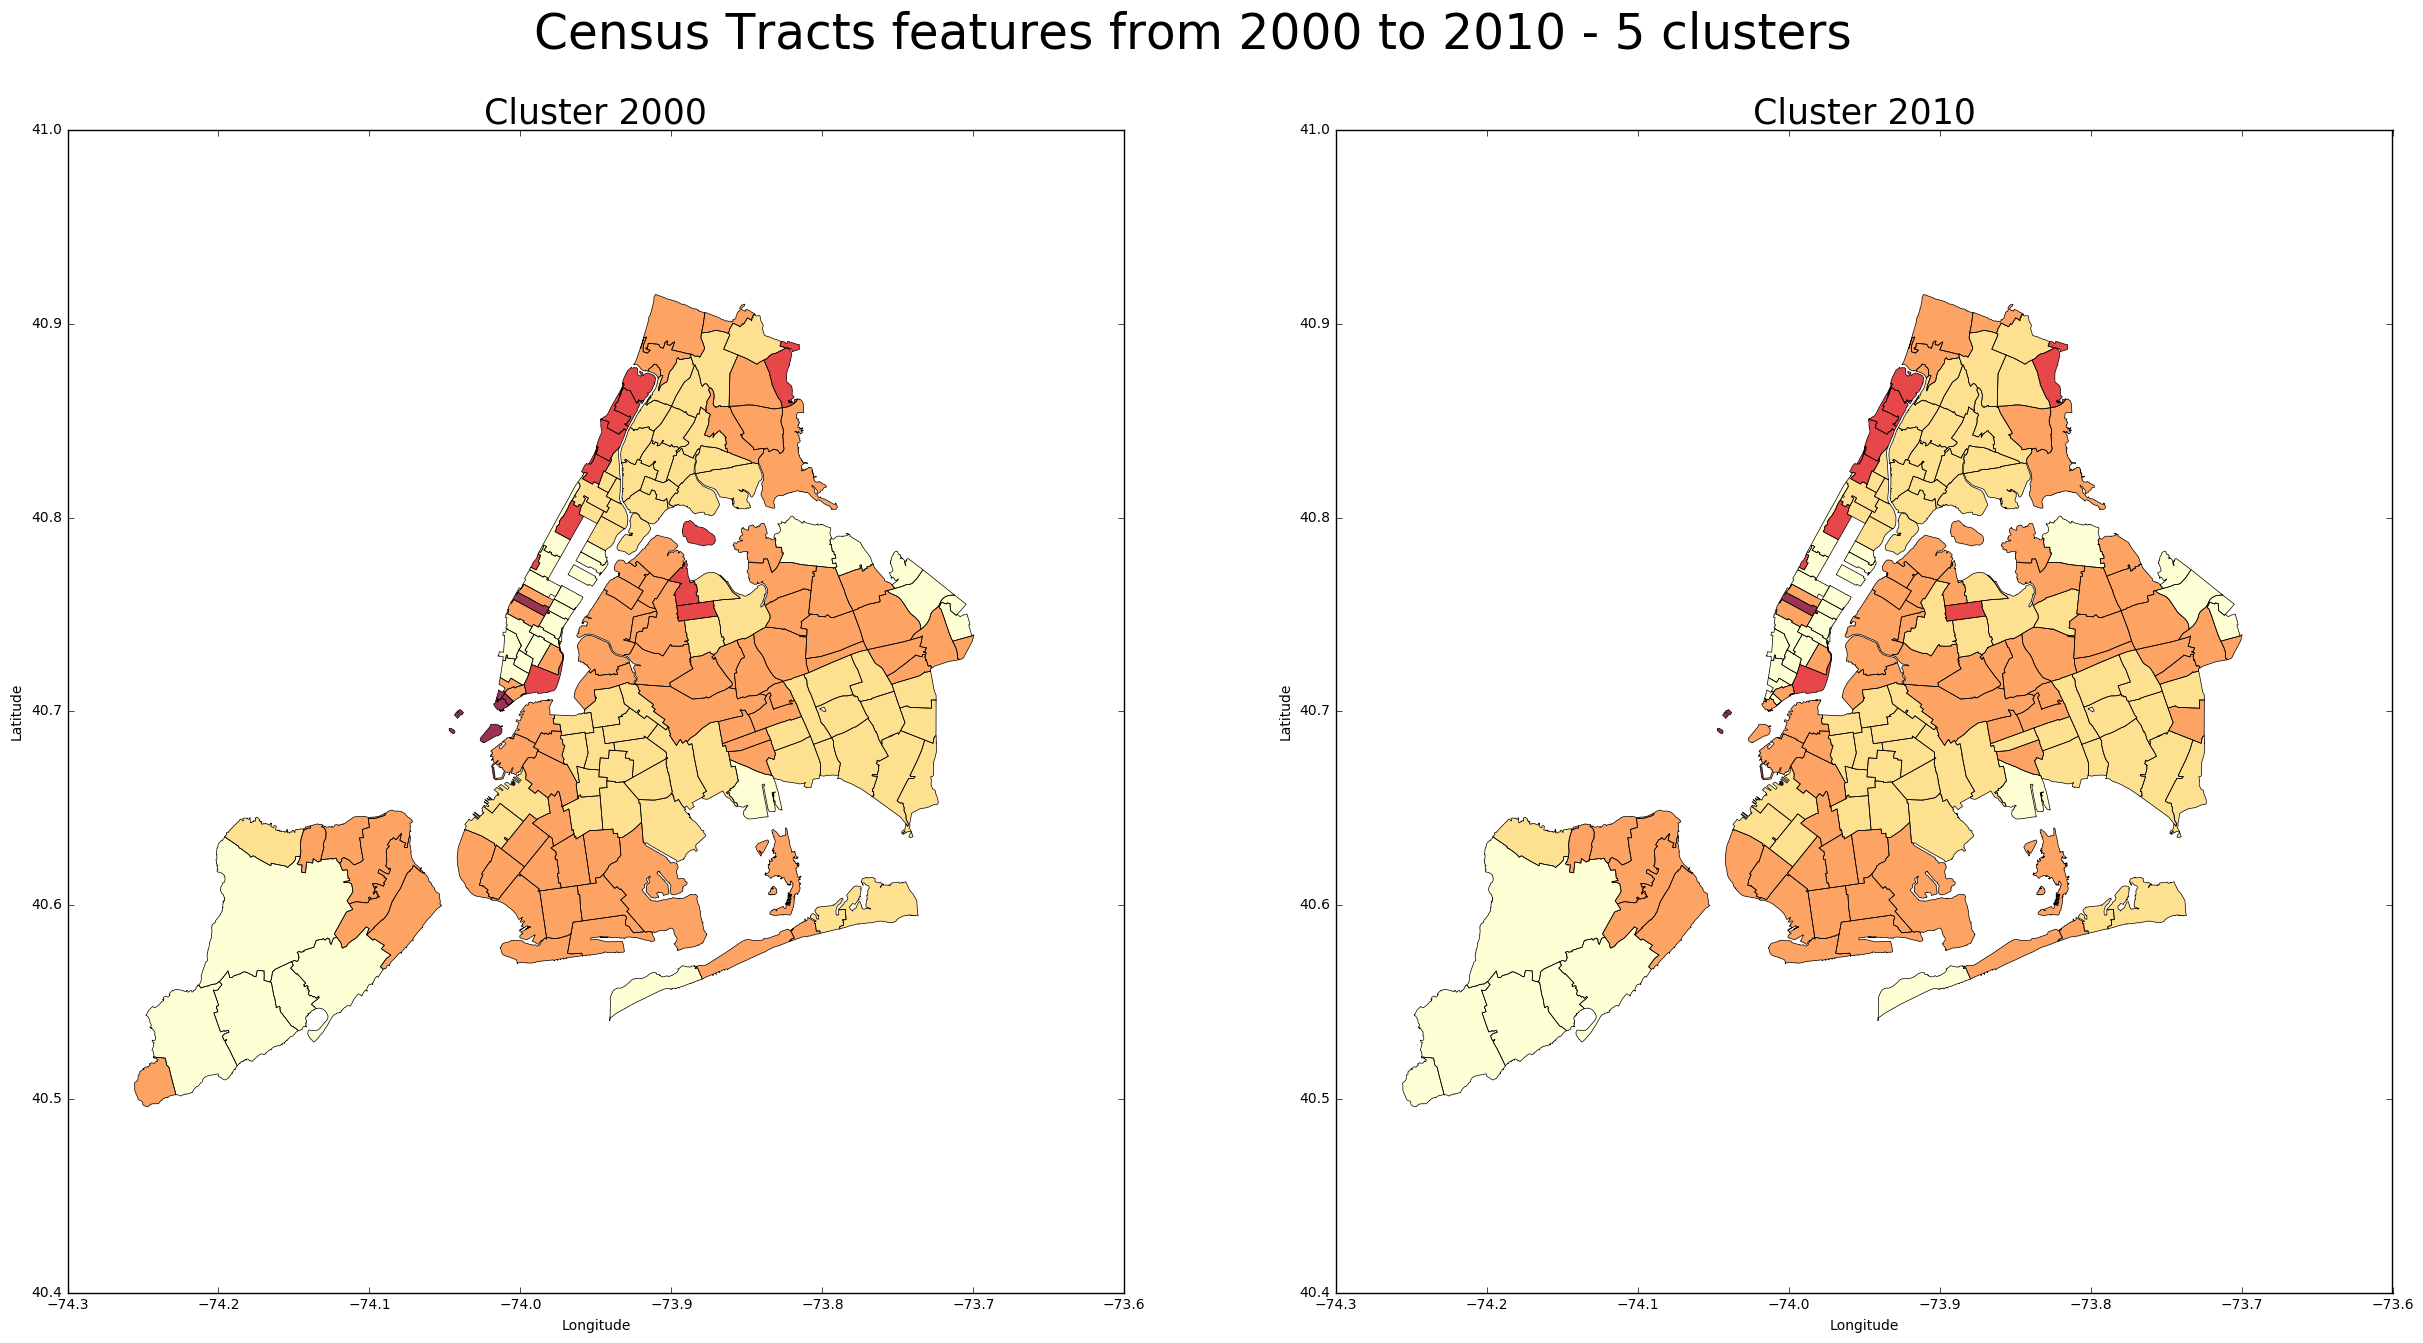

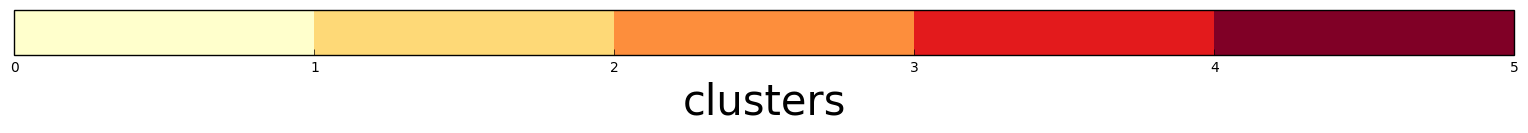

In [434]:
fig = plt.figure(figsize = (30,15))
pl.suptitle('Census Tracts features from 2000 to 2010 - 5 clusters', fontsize=35)
plt.subplot(1,2,1)

ax = fig.add_subplot(121)
cmap = mpl.cm.YlOrRd

zipLevel.plot(alpha=0.8, linewidth=0.5, column = 'cluster_2000', cmap = cmap, ax = ax)
plt.title('Cluster 2000', fontsize = 25)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

ax = fig.add_subplot(122)
zipLevel.plot(alpha=0.8, linewidth=0.5, column = 'cluster_2010', cmap = cmap, ax = ax)
plt.title('Cluster 2010', fontsize = 25)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

fig = pl.figure(figsize=(15, 3))
ax1 = fig.add_axes([0.05, 1.0, 1, 0.15])
norm = mpl.colors.Normalize(vmin=0, vmax=5)
nc = n_clusters

bounds = range(nc + 1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb3 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                norm=norm,
                                ticks=bounds,
                                spacing='uniform',
                                orientation='horizontal')
cb3.set_label('clusters', fontsize=30)


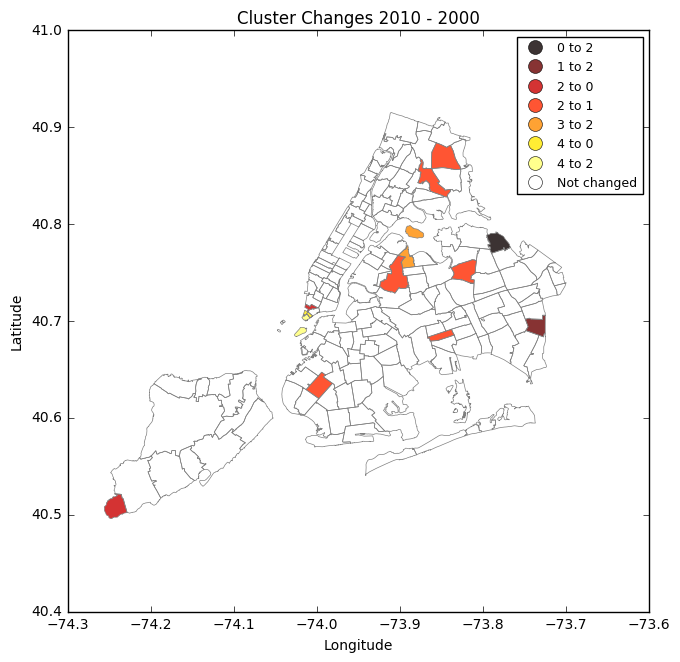

In [435]:
f, ax = plt.subplots(figsize=(7.5, 7.5))
zipLevel.plot(alpha=0.8, linewidth=0.5, column = 'Cluster_Change', 
              cmap = 'hot', categorical=True, ax = ax, edgecolor='grey', legend=True)
plt.title('Cluster Changes 2010 - 2000')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

### 12 - Define a function that given a dataframe containing the relevant information and two cluster labels finds if the census tract changed cluster assignments from the first to the second label, and if so finds the individual features that are significantly different as measured by Pearson's correlation, plot those zip codes, and plot a histogram of the features that have significantly changed. Run your function for all label pairs (2 points, one for the identification of locations that changed cluster and one for the identifiation of the features that changed significantly).

In [453]:
''' This function takes a data, cluster labels and features to be analyzed on this data and return:
        - The zipcodes of census tracts that has changed clusters
        - Calculate pearson's correlation R for each given feature and if it is under 0.8 plot a histogram of the 
          data from 2000 and 2010

    data: the dataframe you want to analyse. This dataframe must contain a census tract and a zipcode information in 
          addition to the features you want to analyze.
    column1 and column2: string type entry that have to be the exact name of the columns of cluster labels 
                         ex: 'cluster_2000'
    features1 and features2: list of name of columns you want to be analyzed. Ex: ["age 2000", "income 2000"]

'''

def cluChange (data, column1, column2, features1, features2):
    
    
# Here we identify which CT has changed clusters from 2000 to 2010
    c1 = data[column1].tolist()
    c2 = data[column2].tolist()
    clusterChange = data[column1] - data[column2]

    for i in range(0, len(clusterChange)):
        if clusterChange[i] != 0:
            clusterChange[i] = str(c1[i]) + ' to ' + str(c2[i])
        else:
            clusterChange[i] = 'Not changed'

# For those who changed, we calculate pearson for each feature input on function
    data1 = data.copy()
    data1['cluster_change'] = clusterChange
    data1 = data1[data1['cluster_change'] != 'Not changed']
    rP = []

# Plot zipcodes which changed clusters
    a=[]
    for i in range(len(data1)):
        try:
            a.append(zipcodes[zipcodes.geometry.intersects(data1.iloc[i].geometry.centroid)].zip.values[0])
        except IndexError:
            a.append(0)
            
    print('Zipcodes of Census Tracts which changed clusters:', list(set(a)))
    
    for i in range(0, len(features1)):
        f1 = data1[features1[i]]
        f2 = data1[features2[i]]
        r_P = scipy.stats.pearsonr(f1, f2)
        rP.append(r_P)
        
# If pearson's R is less than 0.8 we plot a histogram to see feature's behavior
        if rP[i][0] < 0.80:
            print("\nPearson's correlation R for " + features1[i][:-4], rP[i][0])
            pl.figure(figsize = (8, 8))
            h1 = pl.hist(data1[features1[i]], 
                         label = features1[i], normed=True)
            h2 = pl.hist(data1[features2[i]], 
                         label = features2[i], normed=True, alpha = 0.5)
            title = pl.title(str(features1[i]) + ' and ' + str(features2[0]))
            leg = pl.legend()
            pl.xlabel(features1[i][:-4])
            pl.ylabel('Fraction')

    

### The function is defined, let's call for our cluster dataset (Census Tract Level). This function will return the zipcodes and a histogram if needed.

Zipcodes of Census Tracts which changed clusters: [0, 10301, 10302, 10303, 10304, 10305, 10306, 10307, 10309, 10310, 10314, 11354, 11355, 11356, 11357, 11358, 11361, 11362, 11363, 11364, 11365, 11366, 11367, 11368, 11369, 11370, 11372, 11373, 11374, 11375, 11377, 11379, 11385, 11412, 11413, 11415, 11416, 11417, 11418, 11419, 11421, 11423, 11426, 11432, 11433, 11435, 11436, 10451, 10452, 10454, 10457, 10460, 10461, 10462, 10463, 10465, 10466, 10467, 10468, 10471, 10473, 11004, 11005, 10001, 10002, 10003, 10007, 10009, 10010, 10013, 10016, 10017, 10018, 10019, 10021, 10022, 10023, 10025, 10026, 10027, 10028, 10029, 10031, 10032, 10034, 10035, 10036, 10038, 10040, 11101, 11102, 11103, 11105, 11106, 10128, 11691, 11201, 11203, 11204, 11205, 11207, 11208, 11209, 11210, 11211, 11212, 11214, 11215, 11216, 11217, 11218, 11219, 11220, 11221, 11222, 11223, 11224, 11225, 11226, 11228, 11230, 11231, 11233, 11234, 11235, 11236, 11238]

Pearson's correlation R for age  0.753072845263

Pearson's corr

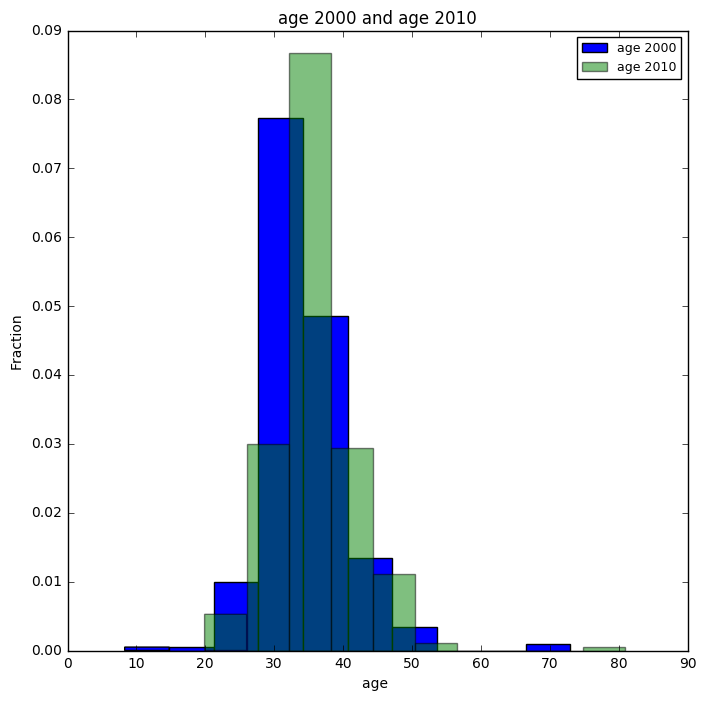

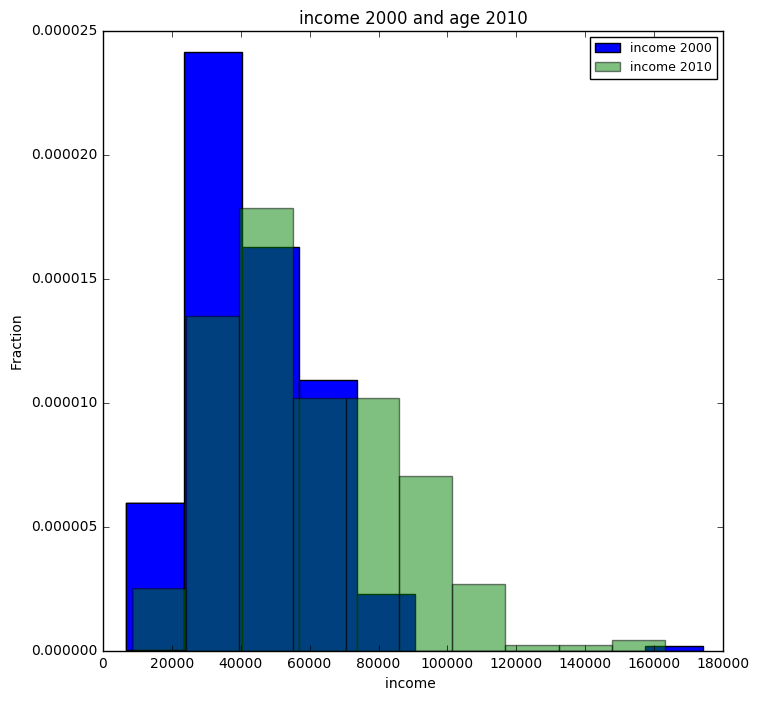

In [454]:
f1 = ["age 2000", "diversity 2000", "income 2000", "population 2000"]
f2 = ["age 2010", "diversity 2010","income 2010", "population 2010"]
cluChange(clusters, 'cluster_2000', 'cluster_2010', f1, f2)


WIth this function we can see the zipcodes of Census Tracts that have changed their clusters in 10 years gap. Analyzing it deeper, we can find that the features that diverge more is those which have the smallest Pearson's R. A Pearson's R not close to 1 mean that they have moderate correlation, so if one increase, the othe increase not at a similar proportion, and that's can be one of the reasons to change cluster. 

About the results we obtained, it's possible to see that the divergency lays on the differences between age and income from 2000 to 2010. In 2010 the changed clusters have become slightly old and have increased considerably the income 

Obs: 
Why the number of zipcodes that has changed clusters is more than 16 (result of clusters on zipcode level)? 
This is because some Census Tracts that have changed clusters are inside zipcodes that on average haven't changed so much to change its clusters on zipcode level clustering. Here in this function we plot the zipcodes of the census tracts that changed clusters, it doesn't mean that the entire zipcode has to change clusters.

### Conclusion

This analysis is interesting to see how the socio-economic characteristics changed from 2000 to 2010, based on number of business, age, income, diversity and population. The clusterization methods allow us to visualize and analyze the changes in a visual and intuitive way.
Further analysis can be done to deep down into a diverging feature like Spatial Correlation analysis.

One of the weaknesses of this analysis is that we are not considering the size of the business that opened or closed in this 10 years, but just the number of those. For example, a company like Apple can be more valuable that 10 companies for the economy of the city. Furthermore, there are some differences on Census Tracts from 2000 to 2010, that can compromise the analysis in some parts of the city.

We can conclude by this analysis that Brooklyn, Bronx and Queens have changed more it's characteristics among all features of this study, becoming more close to Manhattan in population and diversity and income.
It is possible to notice as well that South-west Brooklyn and East Brooklyn are very different. The first one has less income level, is more diverse and on average younger, and the last one is less diverse and has higher income.

Interestingly, Staten Island have presented similarity with MId/south Manhattan, by being in the same cluster in all choropleths, showing that this region have very simillar characteristics of the most famous and economic developed part of NYC.

In general words we can say that NYC has become older in Manhattan and West Brooklyn, and older in the rest of city, and NYC as a whole is getting more diverse and has developed it's income (besides South-west Brooklyn).